In [1]:
import os 
import shutil
from ultralytics import YOLO
import torch
import supervision as sv
from tqdm import tqdm
from transformers import AutoProcessor, SiglipVisionModel
from more_itertools import chunked
import numpy as np


E0000 00:00:1765124844.262469    6758 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765124844.283664    6758 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765124844.445231    6758 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765124844.445294    6758 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765124844.445299    6758 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765124844.445302    6758 computation_placer.cc:177] computation placer already registered. Please check linka

In [2]:
NOTEBOOKS_PATH = os.getcwd()
print(f"Notebook path: {NOTEBOOKS_PATH}")

PROJECT_PATH = os.path.dirname(NOTEBOOKS_PATH)
print(f"Project path: {PROJECT_PATH}")

DATA_PATH = os.path.join(PROJECT_PATH, 'data')
MODELS_PATH = os.path.join(PROJECT_PATH, 'models')
print(f"Data Path: {DATA_PATH}")
print(f"Models Path: {MODELS_PATH}")

MODEL_PATH = os.path.join(MODELS_PATH, 'train5/weights/best.pt')
print(f"Model path: {MODEL_PATH}")

VIDEOS_PATH = os.path.join(DATA_PATH, 'videos')
print(f"Videos path: {VIDEOS_PATH}")

Notebook path: /home/gomaa/Ai/projects/Football-Match-Analysis/notebooks
Project path: /home/gomaa/Ai/projects/Football-Match-Analysis
Data Path: /home/gomaa/Ai/projects/Football-Match-Analysis/data
Models Path: /home/gomaa/Ai/projects/Football-Match-Analysis/models
Model path: /home/gomaa/Ai/projects/Football-Match-Analysis/models/train5/weights/best.pt
Videos path: /home/gomaa/Ai/projects/Football-Match-Analysis/data/videos


In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("CUDA available:", torch.cuda.is_available())
print("GPU count:", torch.cuda.device_count())
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

CUDA available: True
GPU count: 1
Device: NVIDIA GeForce RTX 2050


# Create Embeddings

## Load Model

In [4]:
model = YOLO(MODEL_PATH)

## Videos Paths

In [5]:
VIDEO_NAME = 'vid1.mp4' 
SOURCE_VIDEO_PATH = os.path.join(VIDEOS_PATH, VIDEO_NAME)
print(f"Source Video: {SOURCE_VIDEO_PATH}")

Source Video: /home/gomaa/Ai/projects/Football-Match-Analysis/data/videos/vid1.mp4


### Take Crops

In [6]:
def get_crops(src_vid, stride=30, id=2):
    frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH, stride=stride)

    crops_list = []

    for frame in frame_generator:

        cp_frame = frame.copy()

        result = model.predict(cp_frame, conf=0.3)[0]
        
        detections = sv.Detections.from_ultralytics(result)

        detections = detections.with_nms(threshold=0.5, class_agnostic=True)

        detections = detections[detections.class_id == id]

        crops_list += [
            sv.crop_image(cp_frame, xyxy)
            for xyxy in detections.xyxy
        ]

    return crops_list


In [7]:
STRIDE = 30
PLAYER_ID = 2

crops = get_crops(SOURCE_VIDEO_PATH, STRIDE, PLAYER_ID)


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 86.1ms
Speed: 4.7ms preprocess, 86.1ms inference, 11.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 20 players, 3 referees, 75.5ms
Speed: 4.1ms preprocess, 75.5ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 20 players, 3 referees, 75.8ms
Speed: 3.9ms preprocess, 75.8ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 21 players, 2 referees, 75.8ms
Speed: 5.2ms preprocess, 75.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 22 players, 3 referees, 76.1ms
Speed: 6.7ms preprocess, 76.1ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 22 players, 1 referee, 76.0ms
Speed: 4.1ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 21 players, 3 referees, 75.4ms
Speed: 4.5ms preprocess, 75.4ms inference, 1.1ms postprocess per i

In [9]:
print(f"Number of Crops = {len(crops)}")

Number of Crops = 516


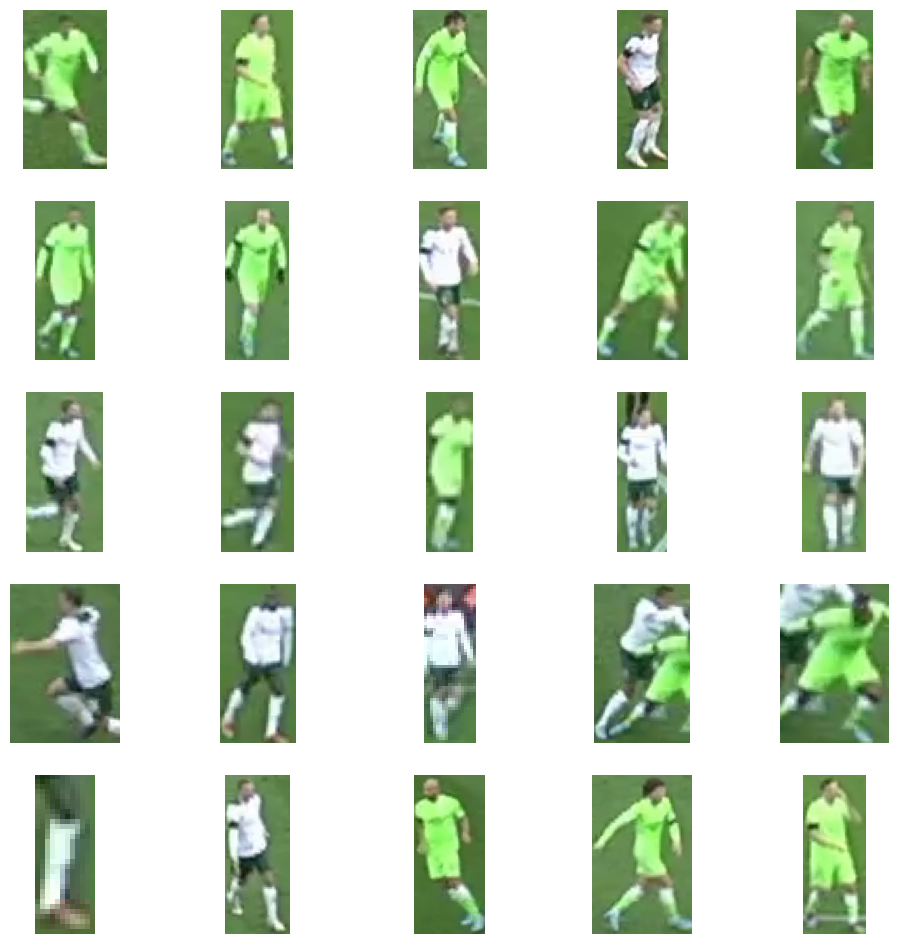

In [10]:
sv.plot_images_grid(crops[:25], grid_size=(5,5))

In [8]:
SIGLIP_MODEL_PATH = 'google/siglip-base-patch16-224'

embeddings_model = SiglipVisionModel.from_pretrained(SIGLIP_MODEL_PATH).to(DEVICE)
embeddings_processor = AutoProcessor.from_pretrained(SIGLIP_MODEL_PATH)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [12]:
BATCH_SIZE = 32
STRIDE = 30
PLAYER_ID = 2

In [ ]:


crops = get_crops(SOURCE_VIDEO_PATH, STRIDE, PLAYER_ID)

crops = [sv.cv2_to_pillow(crop) for crop in crops]
batches = chunked(crops, BATCH_SIZE)

data = []

with torch.no_grad():
    for batch in batches:
        inputs = embeddings_processor(images=batch, return_tensors='pt').to(DEVICE)
        outputs = embeddings_model(**inputs)
        embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()
        data.append(embeddings)

data = np.concatenate(data)
print(data.shape)



0: 576x1024 1 goalkeeper, 21 players, 3 referees, 83.6ms
Speed: 2.6ms preprocess, 83.6ms inference, 8.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 20 players, 3 referees, 73.9ms
Speed: 4.6ms preprocess, 73.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 20 players, 3 referees, 74.0ms
Speed: 3.9ms preprocess, 74.0ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 21 players, 2 referees, 74.2ms
Speed: 5.4ms preprocess, 74.2ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 22 players, 3 referees, 74.1ms
Speed: 5.3ms preprocess, 74.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 22 players, 1 referee, 74.1ms
Speed: 4.1ms preprocess, 74.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 21 players, 3 referees, 74.0ms
Speed: 4.2ms preprocess, 74.0ms inference, 1.0ms postprocess per im

In [9]:
import umap
from sklearn.cluster import KMeans

In [10]:
class TeamClassifier():
    def __init__(self, device):
        self.device = device
        self.SIGLIP_MODEL_PATH = 'google/siglip-base-patch16-224'
        self.dim_reducer = umap.UMAP(n_components=3)
        self.clustering_model = KMeans(n_clusters=2)

    def create_embeddings(self, crops):
        embeddings_model = SiglipVisionModel.from_pretrained(self.SIGLIP_MODEL_PATH).to(self.device)
        embeddings_processor = AutoProcessor.from_pretrained(self.SIGLIP_MODEL_PATH)

        crops = [sv.cv2_to_pillow(crop) for crop in crops]
        batches = chunked(crops, BATCH_SIZE)

        data = []

        with torch.no_grad():
            for batch in batches:
                inputs = embeddings_processor(images=batch, return_tensors='pt').to(self.device)
                outputs = embeddings_model(**inputs)
                embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()
                data.append(embeddings)

        data = np.concatenate(data)
        
        
        return data

    def fit(self, crops):
        embeddings = self.create_embeddings(crops)
        projections = self.dim_reducer.fit_transform(embeddings)
        self.clusters = self.clustering_model.fit_predict(projections)
        return self.clusters
    
    def predict(self, crops):
        embeddings = self.create_embeddings(crops)
        projections = self.dim_reducer.transform(embeddings)
        clusters = self.clustering_model.predict(projections)

        return clusters



0: 576x1024 1 goalkeeper, 21 players, 3 referees, 81.3ms
Speed: 23.2ms preprocess, 81.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 20 players, 3 referees, 80.9ms
Speed: 4.0ms preprocess, 80.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 20 players, 3 referees, 75.9ms
Speed: 4.2ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 21 players, 2 referees, 76.3ms
Speed: 3.5ms preprocess, 76.3ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 22 players, 3 referees, 76.4ms
Speed: 4.5ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 22 players, 1 referee, 75.8ms
Speed: 3.3ms preprocess, 75.8ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 21 players, 3 referees, 75.9ms
Speed: 3.5ms preprocess, 75.9ms inference, 1.0ms postprocess per i

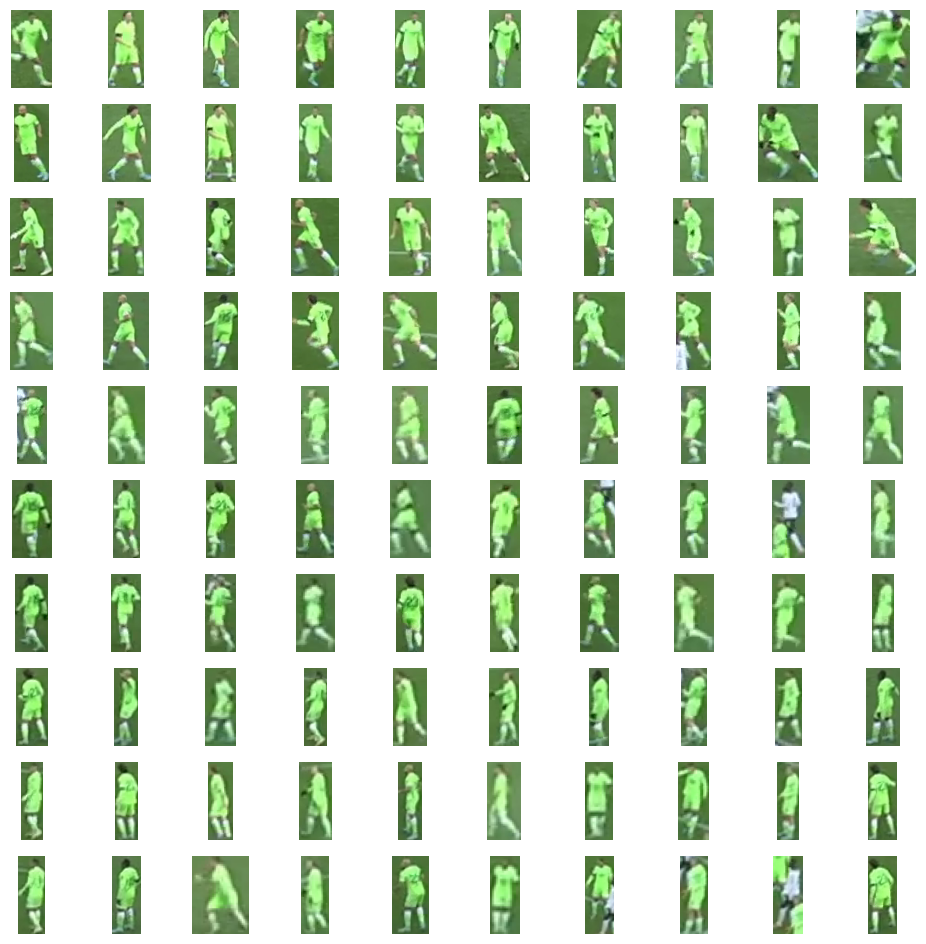

In [13]:
team_classifier = TeamClassifier(DEVICE)
crops = get_crops(SOURCE_VIDEO_PATH)
team_classifier.fit(crops)
preds = team_classifier.predict(crops)
team_1 = [
    crop
    for crop, cluster in zip(crops, preds)
    if cluster == 0
]

team_2 = [
    crop
    for crop, cluster in zip(crops, preds)
    if cluster == 1
]

sv.plot_images_grid(team_1[:100], grid_size=(10,10))

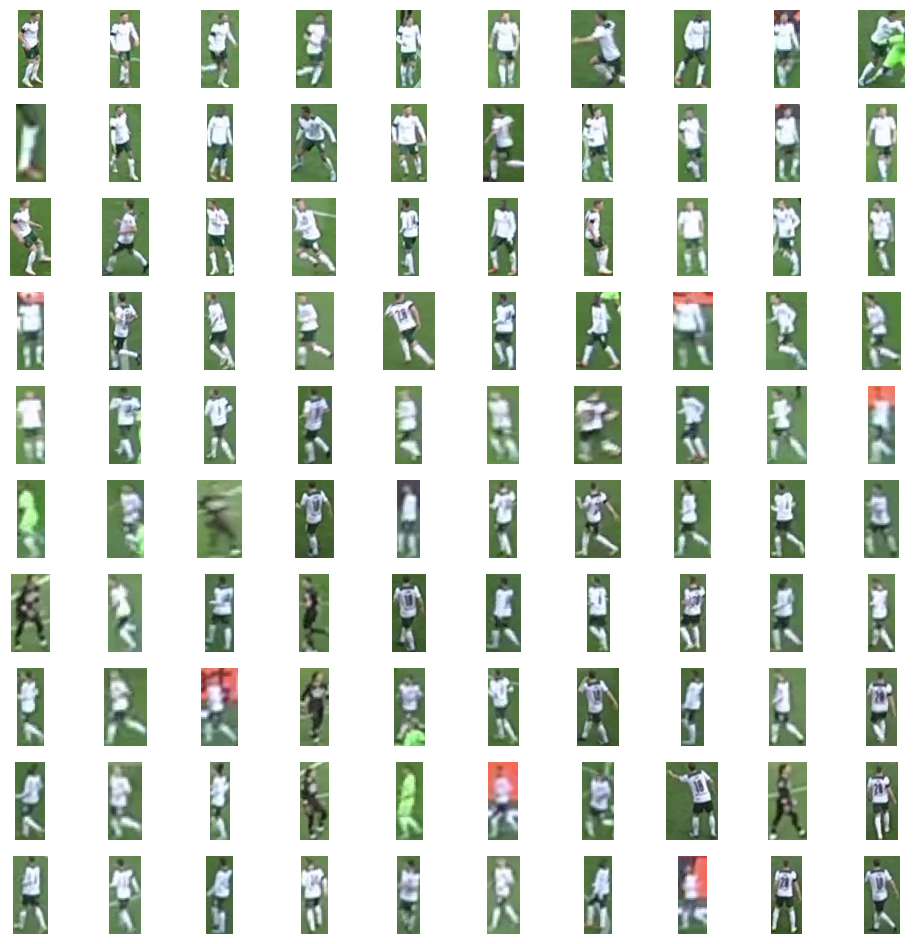

In [14]:
sv.plot_images_grid(team_2[:100], grid_size=(10,10))


In [11]:
dim_reducer = umap.UMAP(n_components=3)
clustering_model = KMeans(n_clusters=2)

In [12]:
embeddings = data.copy()
projections = dim_reducer.fit_transform(embeddings)

print(f"Shape of Embeddings = {embeddings.shape}")
print(f"Shape of Embeddings Projections = {projections.shape}")

Shape of Embeddings = (516, 768)
Shape of Embeddings Projections = (516, 3)


In [13]:
clusters = clustering_model.fit_predict(projections)

In [14]:
print(clusters[:10])

[1 1 1 0 1 1 1 0 1 1]


In [15]:
team_1 = [
    crop
    for crop, cluster in zip(crops, clusters)
    if cluster == 0
]

team_2 = [
    crop
    for crop, cluster in zip(crops, clusters)
    if cluster == 1
]

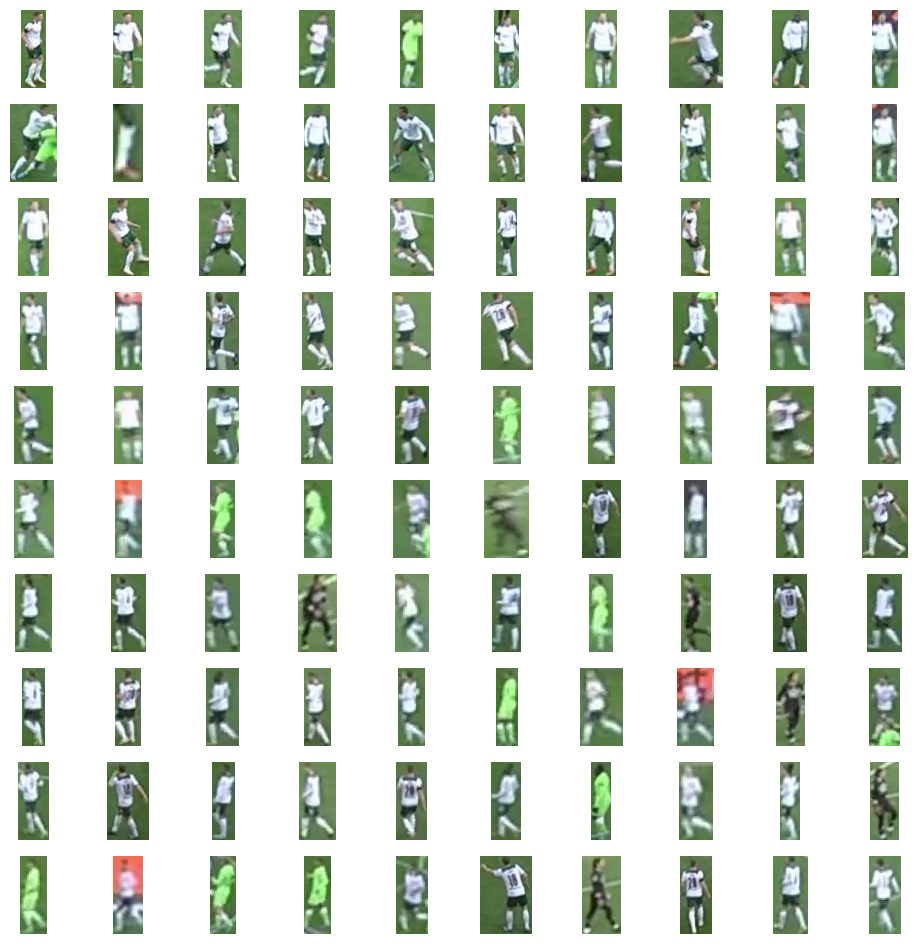

In [18]:
sv.plot_images_grid(team_1[:100], grid_size=(10,10))

In [15]:
RESULT_VIDEO_PATH = os.path.join(DATA_PATH, 'results-videos')
print(f"Result videos path: {RESULT_VIDEO_PATH}")

Result videos path: /home/gomaa/Ai/projects/Football-Match-Analysis/data/results-videos



0: 576x1024 1 goalkeeper, 21 players, 3 referees, 81.4ms
Speed: 19.5ms preprocess, 81.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 20 players, 3 referees, 77.3ms
Speed: 4.3ms preprocess, 77.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 20 players, 3 referees, 76.2ms
Speed: 4.5ms preprocess, 76.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 21 players, 2 referees, 76.1ms
Speed: 5.5ms preprocess, 76.1ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 22 players, 3 referees, 75.9ms
Speed: 5.6ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 22 players, 1 referee, 76.5ms
Speed: 3.4ms preprocess, 76.5ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 21 players, 3 referees, 76.4ms
Speed: 5.4ms preprocess, 76.4ms inference, 1.0ms postprocess per i

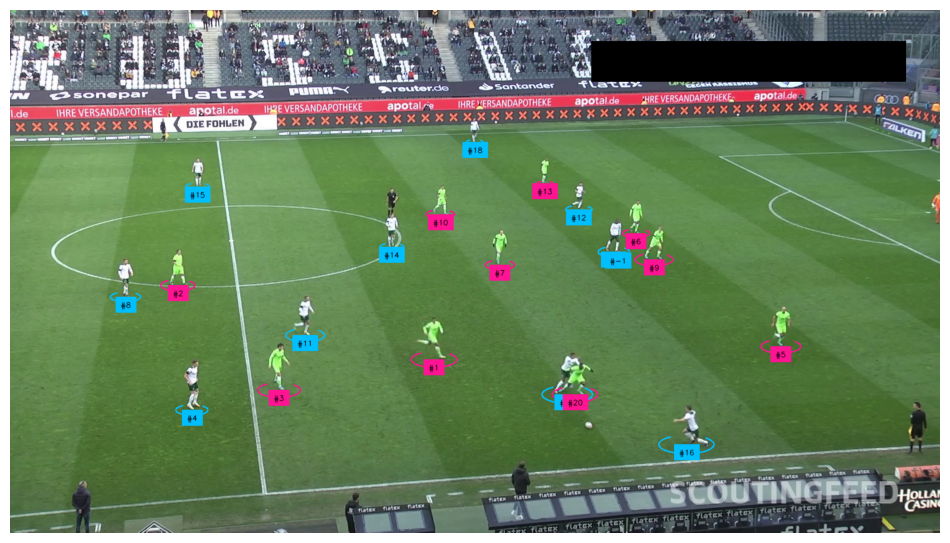

In [16]:
TARGET_VIDEO_PATH = os.path.join(RESULT_VIDEO_PATH, 'vid1_resTrack1.mp4')

colors_list = ['#00BFFF','#FF1493','#FFE876']

BALL_ID = 0

ellipse_annot = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(colors_list),
    thickness=2
)

label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(colors_list),
    text_color=sv.Color.from_hex("#000000"),
    text_position=sv.Position.BOTTOM_CENTER
)

triangle_annot = sv.TriangleAnnotator(
    color= sv.Color.from_hex('#9E5700'),
    base=20, height=17
)

tracker = sv.ByteTrack()
tracker.reset()

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)


team_classifier = TeamClassifier(DEVICE)
crops = get_crops(SOURCE_VIDEO_PATH)
team_classifier.fit(crops)


result = model.predict(frame, conf=0.25)[0]

detections = sv.Detections.from_ultralytics(result)

ball_detections = detections[detections.class_id==BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

other_detections = detections[detections.class_id!=BALL_ID]
other_detections = other_detections.with_nms(threshold=0.5, class_agnostic=True)


players_detections = other_detections[other_detections.class_id==PLAYER_ID]
players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
players_detections.class_id = team_classifier.predict(players_crops)
other_detections = tracker.update_with_detections(players_detections)




labels = [
    f"#{tracker_id}"
    for tracker_id in players_detections.tracker_id
]



annotated_frame = frame.copy()
annotated_frame = ellipse_annot.annotate(scene=annotated_frame, detections=other_detections)
annotated_frame = triangle_annot.annotate(scene=annotated_frame, detections=ball_detections)
annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=players_detections, labels=labels)
sv.plot_image(annotated_frame)


## Add Goalkeeper

In [18]:
def get_goalkeepers_teams(players_detections, goalkeeper_detections):
    goalkeepers_xy = goalkeeper_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    players_xy = players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)

    team1_centroid = players_xy[players_detections.class_id == 0].mean(axis=0)
    team2_centroid = players_xy[players_detections.class_id == 1].mean(axis=0)

    goalkeepers_team_ids = []

    for goalkeeper_xy in goalkeepers_xy:
        dist_to_team1 = np.linalg.norm(goalkeepers_xy - team1_centroid)
        dist_to_team2 = np.linalg.norm(goalkeepers_xy - team2_centroid)

        goalkeepers_team_ids.append(0 if dist_to_team1 < dist_to_team2 else 1 )

    return np.array(goalkeepers_team_ids)



0: 576x1024 1 goalkeeper, 21 players, 3 referees, 81.4ms
Speed: 19.6ms preprocess, 81.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 20 players, 3 referees, 76.7ms
Speed: 3.6ms preprocess, 76.7ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 20 players, 3 referees, 76.2ms
Speed: 3.7ms preprocess, 76.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 21 players, 2 referees, 75.7ms
Speed: 4.4ms preprocess, 75.7ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 22 players, 3 referees, 76.2ms
Speed: 3.9ms preprocess, 76.2ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 22 players, 1 referee, 75.8ms
Speed: 3.5ms preprocess, 75.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 21 players, 3 referees, 76.2ms
Speed: 4.1ms preprocess, 76.2ms inference, 1.0ms postprocess per i

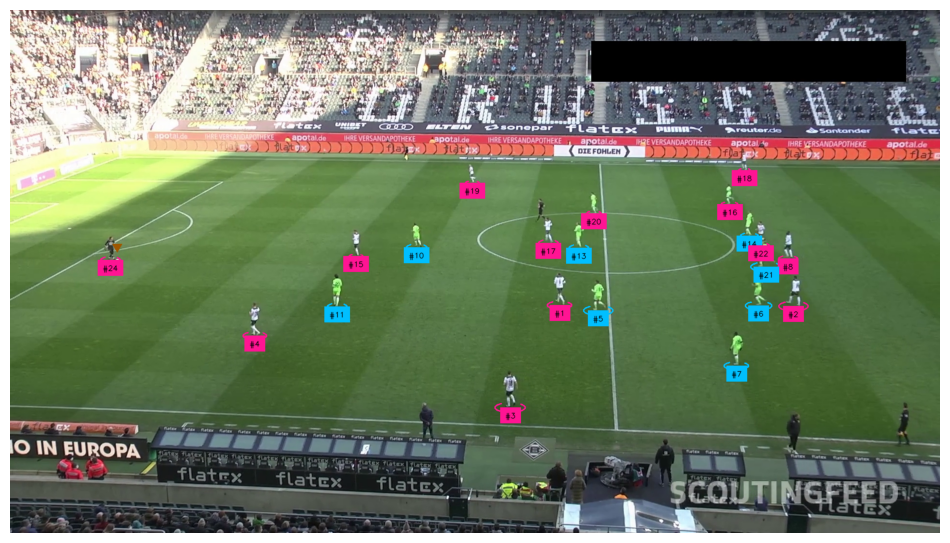

In [23]:
TARGET_VIDEO_PATH = os.path.join(RESULT_VIDEO_PATH, 'vid1_resTrack1.mp4')

colors_list = ['#00BFFF','#FF1493','#FFE876']

BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
ellipse_annot = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(colors_list),
    thickness=2
)

label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(colors_list),
    text_color=sv.Color.from_hex("#000000"),
    text_position=sv.Position.BOTTOM_CENTER
)

triangle_annot = sv.TriangleAnnotator(
    color= sv.Color.from_hex('#9E5700'),
    base=20, height=17
)

tracker = sv.ByteTrack()
tracker.reset()

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
fps = video_info.fps

target_second = 7
target_frame_idx = int(target_second * fps)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

frame = None
for i in range(target_frame_idx + 1):
    frame = next(frame_generator)

team_classifier = TeamClassifier(DEVICE)
crops = get_crops(SOURCE_VIDEO_PATH)
team_classifier.fit(crops)


result = model.predict(frame, conf=0.25)[0]

detections = sv.Detections.from_ultralytics(result)

ball_detections = detections[detections.class_id==BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

other_detections = detections[detections.class_id!=BALL_ID]
other_detections = other_detections.with_nms(threshold=0.5, class_agnostic=True)
other_detections = tracker.update_with_detections(other_detections)


players_detections = other_detections[other_detections.class_id==PLAYER_ID]
goalkeepers_detections = players_detections[players_detections.class_id == GOALKEEPER_ID]

players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]

players_detections.class_id = team_classifier.predict(players_crops)
goalkeepers_detections.class_id = get_goalkeepers_teams(players_detections, goalkeepers_detections).astype(int)

other_detections = sv.Detections.merge([players_detections, goalkeepers_detections])


labels = [
    f"#{tracker_id}"
    for tracker_id in players_detections.tracker_id
]



annotated_frame = frame.copy()
annotated_frame = ellipse_annot.annotate(scene=annotated_frame, detections=other_detections)
annotated_frame = triangle_annot.annotate(scene=annotated_frame, detections=ball_detections)
annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=other_detections, labels=labels)
sv.plot_image(annotated_frame)


## ADD Referees


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 80.7ms
Speed: 19.1ms preprocess, 80.7ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 20 players, 3 referees, 76.3ms
Speed: 3.1ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 20 players, 3 referees, 75.7ms
Speed: 3.2ms preprocess, 75.7ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 21 players, 2 referees, 76.2ms
Speed: 3.2ms preprocess, 76.2ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 22 players, 3 referees, 76.2ms
Speed: 3.6ms preprocess, 76.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 22 players, 1 referee, 76.2ms
Speed: 3.6ms preprocess, 76.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 21 players, 3 referees, 75.6ms
Speed: 4.2ms preprocess, 75.6ms inference, 0.9ms postprocess per i

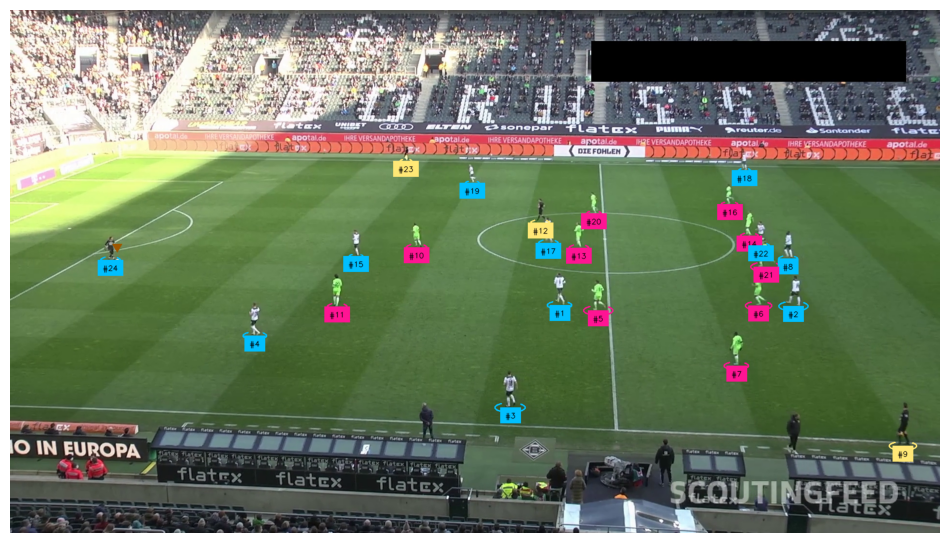

In [ ]:
TARGET_VIDEO_PATH = os.path.join(RESULT_VIDEO_PATH, 'vid1_resTrack1.mp4')

colors_list = ['#00BFFF','#FF1493','#FFE876']

BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3
ellipse_annot = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(colors_list),
    thickness=2
)

label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(colors_list),
    text_color=sv.Color.from_hex("#000000"),
    text_position=sv.Position.BOTTOM_CENTER
)

triangle_annot = sv.TriangleAnnotator(
    color= sv.Color.from_hex('#9E5700'),
    base=20, height=17
)

tracker = sv.ByteTrack()
tracker.reset()

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
fps = video_info.fps

target_second = 7
target_frame_idx = int(target_second * fps)


frame = None
for i in range(target_frame_idx + 1):
    frame = next(frame_generator)

team_classifier = TeamClassifier(DEVICE)
crops = get_crops(SOURCE_VIDEO_PATH)
team_classifier.fit(crops)


result = model.predict(frame, conf=0.25)[0]

detections = sv.Detections.from_ultralytics(result)

ball_detections = detections[detections.class_id==BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

other_detections = detections[detections.class_id!=BALL_ID]
other_detections = other_detections.with_nms(threshold=0.5, class_agnostic=True)
other_detections = tracker.update_with_detections(other_detections)


players_detections = other_detections[other_detections.class_id==PLAYER_ID]
goalkeepers_detections = players_detections[players_detections.class_id == GOALKEEPER_ID]
referees_detections = other_detections[other_detections.class_id==REFEREE_ID]

players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]

players_detections.class_id = team_classifier.predict(players_crops)
goalkeepers_detections.class_id = get_goalkeepers_teams(players_detections, goalkeepers_detections).astype(int)
referees_detections.class_id -= 1
other_detections = sv.Detections.merge([players_detections, goalkeepers_detections, referees_detections])


labels = [
    f"#{tracker_id}"
    for tracker_id in other_detections.tracker_id
]



annotated_frame = frame.copy()
annotated_frame = ellipse_annot.annotate(scene=annotated_frame, detections=other_detections)
annotated_frame = triangle_annot.annotate(scene=annotated_frame, detections=ball_detections)
annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=other_detections, labels=labels)
sv.plot_image(annotated_frame)


# Test on a video

In [26]:
TARGET_VIDEO_PATH = os.path.join(RESULT_VIDEO_PATH, 'vid1_resTrack_with_teams.mp4')

colors_list = ['#00BFFF','#FF1493','#FFE876']

BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

ellipse_annot = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(colors_list),
    thickness=2
)

label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(colors_list),
    text_color=sv.Color.from_hex("#000000"),
    text_position=sv.Position.BOTTOM_CENTER
)

triangle_annot = sv.TriangleAnnotator(
    color= sv.Color.from_hex('#9E5700'),
    base=20, height=17
)

tracker = sv.ByteTrack()
tracker.reset()

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

team_classifier = TeamClassifier(DEVICE)
crops = get_crops(SOURCE_VIDEO_PATH)
team_classifier.fit(crops)


with video_sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):
        result = model.predict(frame, conf=0.25)[0]

        detections = sv.Detections.from_ultralytics(result)

        ball_detections = detections[detections.class_id==BALL_ID]
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

        other_detections = detections[detections.class_id!=BALL_ID]
        other_detections = other_detections.with_nms(threshold=0.5, class_agnostic=True)
        other_detections = tracker.update_with_detections(other_detections)


        players_detections = other_detections[other_detections.class_id==PLAYER_ID]
        goalkeepers_detections = players_detections[players_detections.class_id == GOALKEEPER_ID]
        referees_detections = other_detections[other_detections.class_id==REFEREE_ID]

        players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]

        players_detections.class_id = team_classifier.predict(players_crops)
        goalkeepers_detections.class_id = get_goalkeepers_teams(players_detections, goalkeepers_detections).astype(int)
        referees_detections.class_id -= 1
        other_detections = sv.Detections.merge([players_detections, goalkeepers_detections, referees_detections])


        labels = [
            f"#{tracker_id}"
            for tracker_id in other_detections.tracker_id
        ]


        annotated_frame = frame.copy()
        annotated_frame = ellipse_annot.annotate(scene=annotated_frame, detections=other_detections)
        annotated_frame = triangle_annot.annotate(scene=annotated_frame, detections=ball_detections)
        annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=other_detections, labels=labels)
        video_sink.write_frame(frame=annotated_frame)




0: 576x1024 1 goalkeeper, 21 players, 3 referees, 81.7ms
Speed: 18.1ms preprocess, 81.7ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 20 players, 3 referees, 80.1ms
Speed: 4.4ms preprocess, 80.1ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 20 players, 3 referees, 80.3ms
Speed: 3.2ms preprocess, 80.3ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 21 players, 2 referees, 75.8ms
Speed: 4.2ms preprocess, 75.8ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 22 players, 3 referees, 75.8ms
Speed: 4.2ms preprocess, 75.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 22 players, 1 referee, 75.8ms
Speed: 3.6ms preprocess, 75.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 21 players, 3 referees, 76.3ms
Speed: 3.2ms preprocess, 76.3ms inference, 1.0ms postprocess per i

  0%|          | 0/750 [00:00<?, ?it/s]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 76.3ms
Speed: 2.7ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


  0%|          | 1/750 [00:04<53:02,  4.25s/it]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 76.4ms
Speed: 4.0ms preprocess, 76.4ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)


  0%|          | 2/750 [00:07<48:38,  3.90s/it]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.8ms
Speed: 3.2ms preprocess, 75.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


  0%|          | 3/750 [00:11<46:48,  3.76s/it]


0: 576x1024 1 goalkeeper, 20 players, 2 referees, 76.4ms
Speed: 3.4ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


  1%|          | 4/750 [00:15<49:21,  3.97s/it]


0: 576x1024 1 goalkeeper, 22 players, 2 referees, 75.8ms
Speed: 3.6ms preprocess, 75.8ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)


  1%|          | 5/750 [00:19<48:35,  3.91s/it]


0: 576x1024 1 goalkeeper, 22 players, 2 referees, 75.8ms
Speed: 4.1ms preprocess, 75.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


  1%|          | 6/750 [00:23<49:33,  4.00s/it]


0: 576x1024 1 goalkeeper, 23 players, 2 referees, 76.4ms
Speed: 3.1ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


  1%|          | 7/750 [00:27<48:18,  3.90s/it]


0: 576x1024 1 goalkeeper, 22 players, 2 referees, 76.3ms
Speed: 3.2ms preprocess, 76.3ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


  1%|          | 8/750 [00:31<47:09,  3.81s/it]


0: 576x1024 1 goalkeeper, 21 players, 2 referees, 76.4ms
Speed: 3.1ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


  1%|          | 9/750 [00:34<46:33,  3.77s/it]


0: 576x1024 1 ball, 1 goalkeeper, 24 players, 2 referees, 76.1ms
Speed: 4.3ms preprocess, 76.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


  1%|▏         | 10/750 [00:38<47:17,  3.84s/it]


0: 576x1024 1 goalkeeper, 24 players, 2 referees, 76.4ms
Speed: 3.7ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


  1%|▏         | 11/750 [00:42<46:32,  3.78s/it]


0: 576x1024 1 goalkeeper, 24 players, 2 referees, 76.3ms
Speed: 3.4ms preprocess, 76.3ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


  2%|▏         | 12/750 [00:46<46:31,  3.78s/it]


0: 576x1024 1 goalkeeper, 25 players, 2 referees, 76.0ms
Speed: 3.1ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


  2%|▏         | 13/750 [00:50<46:42,  3.80s/it]


0: 576x1024 1 goalkeeper, 23 players, 2 referees, 76.2ms
Speed: 2.9ms preprocess, 76.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


  2%|▏         | 14/750 [00:54<47:25,  3.87s/it]


0: 576x1024 20 players, 3 referees, 75.9ms
Speed: 3.1ms preprocess, 75.9ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


  2%|▏         | 15/750 [00:58<49:26,  4.04s/it]


0: 576x1024 20 players, 3 referees, 75.9ms
Speed: 4.1ms preprocess, 75.9ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


  2%|▏         | 16/750 [01:02<49:04,  4.01s/it]


0: 576x1024 21 players, 3 referees, 75.9ms
Speed: 3.8ms preprocess, 75.9ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)


  2%|▏         | 17/750 [01:06<48:20,  3.96s/it]


0: 576x1024 21 players, 3 referees, 75.9ms
Speed: 3.4ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


  2%|▏         | 18/750 [01:10<50:40,  4.15s/it]


0: 576x1024 21 players, 3 referees, 76.3ms
Speed: 3.0ms preprocess, 76.3ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)


  3%|▎         | 19/750 [01:15<50:57,  4.18s/it]


0: 576x1024 23 players, 3 referees, 76.4ms
Speed: 3.5ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


  3%|▎         | 20/750 [01:18<49:27,  4.07s/it]


0: 576x1024 20 players, 3 referees, 76.1ms
Speed: 3.0ms preprocess, 76.1ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


  3%|▎         | 21/750 [01:22<48:35,  4.00s/it]


0: 576x1024 20 players, 5 referees, 75.9ms
Speed: 3.0ms preprocess, 75.9ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


  3%|▎         | 22/750 [01:26<48:29,  4.00s/it]


0: 576x1024 20 players, 4 referees, 76.4ms
Speed: 2.9ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


  3%|▎         | 23/750 [01:30<48:40,  4.02s/it]


0: 576x1024 21 players, 3 referees, 75.9ms
Speed: 3.8ms preprocess, 75.9ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


  3%|▎         | 24/750 [01:34<47:15,  3.91s/it]


0: 576x1024 23 players, 3 referees, 75.9ms
Speed: 2.9ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


  3%|▎         | 25/750 [01:38<46:07,  3.82s/it]


0: 576x1024 22 players, 3 referees, 76.5ms
Speed: 2.9ms preprocess, 76.5ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


  3%|▎         | 26/750 [01:42<46:34,  3.86s/it]


0: 576x1024 22 players, 3 referees, 76.2ms
Speed: 3.6ms preprocess, 76.2ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


  4%|▎         | 27/750 [01:45<46:41,  3.87s/it]


0: 576x1024 21 players, 3 referees, 76.1ms
Speed: 4.3ms preprocess, 76.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


  4%|▎         | 28/750 [01:49<45:48,  3.81s/it]


0: 576x1024 21 players, 3 referees, 75.8ms
Speed: 4.3ms preprocess, 75.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


  4%|▍         | 29/750 [02:03<1:20:39,  6.71s/it]


0: 576x1024 20 players, 4 referees, 76.1ms
Speed: 3.5ms preprocess, 76.1ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)


  4%|▍         | 30/750 [02:06<1:09:12,  5.77s/it]


0: 576x1024 20 players, 3 referees, 75.8ms
Speed: 3.3ms preprocess, 75.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


  4%|▍         | 31/750 [02:10<1:01:09,  5.10s/it]


0: 576x1024 22 players, 3 referees, 76.0ms
Speed: 3.1ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


  4%|▍         | 32/750 [02:14<57:42,  4.82s/it]  


0: 576x1024 21 players, 3 referees, 76.3ms
Speed: 3.2ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


  4%|▍         | 33/750 [02:18<54:51,  4.59s/it]


0: 576x1024 21 players, 3 referees, 76.3ms
Speed: 3.5ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


  5%|▍         | 34/750 [02:22<54:18,  4.55s/it]


0: 576x1024 20 players, 3 referees, 76.4ms
Speed: 3.2ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


  5%|▍         | 35/750 [02:26<52:29,  4.41s/it]


0: 576x1024 20 players, 3 referees, 75.9ms
Speed: 3.5ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


  5%|▍         | 36/750 [02:31<52:36,  4.42s/it]


0: 576x1024 20 players, 3 referees, 76.2ms
Speed: 4.2ms preprocess, 76.2ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


  5%|▍         | 37/750 [02:45<1:25:30,  7.20s/it]


0: 576x1024 20 players, 3 referees, 76.3ms
Speed: 3.6ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


  5%|▌         | 38/750 [02:48<1:12:29,  6.11s/it]


0: 576x1024 1 ball, 20 players, 3 referees, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)


  5%|▌         | 39/750 [02:52<1:03:25,  5.35s/it]


0: 576x1024 20 players, 3 referees, 76.2ms
Speed: 4.2ms preprocess, 76.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


  5%|▌         | 40/750 [02:56<58:06,  4.91s/it]  


0: 576x1024 21 players, 3 referees, 75.9ms
Speed: 3.2ms preprocess, 75.9ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


  5%|▌         | 41/750 [02:59<54:13,  4.59s/it]


0: 576x1024 21 players, 3 referees, 75.8ms
Speed: 2.7ms preprocess, 75.8ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


  6%|▌         | 42/750 [03:04<52:23,  4.44s/it]


0: 576x1024 24 players, 2 referees, 75.9ms
Speed: 4.5ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


  6%|▌         | 43/750 [03:07<49:23,  4.19s/it]


0: 576x1024 22 players, 3 referees, 75.8ms
Speed: 2.8ms preprocess, 75.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


  6%|▌         | 44/750 [03:11<48:46,  4.15s/it]


0: 576x1024 1 ball, 22 players, 3 referees, 75.4ms
Speed: 3.6ms preprocess, 75.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


  6%|▌         | 45/750 [03:15<46:41,  3.97s/it]


0: 576x1024 21 players, 3 referees, 75.3ms
Speed: 3.4ms preprocess, 75.3ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)


  6%|▌         | 46/750 [03:19<46:18,  3.95s/it]


0: 576x1024 1 ball, 22 players, 3 referees, 75.3ms
Speed: 3.2ms preprocess, 75.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


  6%|▋         | 47/750 [03:22<45:44,  3.90s/it]


0: 576x1024 21 players, 3 referees, 76.0ms
Speed: 4.1ms preprocess, 76.0ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


  6%|▋         | 48/750 [03:27<46:21,  3.96s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 75.9ms
Speed: 3.4ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


  7%|▋         | 49/750 [03:30<45:55,  3.93s/it]


0: 576x1024 21 players, 5 referees, 75.4ms
Speed: 3.5ms preprocess, 75.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


  7%|▋         | 50/750 [03:35<48:13,  4.13s/it]


0: 576x1024 22 players, 5 referees, 75.5ms
Speed: 3.5ms preprocess, 75.5ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


  7%|▋         | 51/750 [03:39<47:29,  4.08s/it]


0: 576x1024 21 players, 3 referees, 75.4ms
Speed: 3.6ms preprocess, 75.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


  7%|▋         | 52/750 [03:43<45:41,  3.93s/it]


0: 576x1024 20 players, 2 referees, 75.9ms
Speed: 3.1ms preprocess, 75.9ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


  7%|▋         | 53/750 [03:46<44:07,  3.80s/it]


0: 576x1024 20 players, 2 referees, 75.9ms
Speed: 4.3ms preprocess, 75.9ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


  7%|▋         | 54/750 [03:50<44:36,  3.85s/it]


0: 576x1024 24 players, 3 referees, 76.1ms
Speed: 3.3ms preprocess, 76.1ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


  7%|▋         | 55/750 [03:54<46:34,  4.02s/it]


0: 576x1024 20 players, 4 referees, 75.7ms
Speed: 4.0ms preprocess, 75.7ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


  7%|▋         | 56/750 [04:00<50:14,  4.34s/it]


0: 576x1024 21 players, 3 referees, 75.8ms
Speed: 3.8ms preprocess, 75.8ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


  8%|▊         | 57/750 [04:03<47:25,  4.11s/it]


0: 576x1024 20 players, 2 referees, 75.6ms
Speed: 4.2ms preprocess, 75.6ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


  8%|▊         | 58/750 [04:07<45:29,  3.94s/it]


0: 576x1024 20 players, 2 referees, 75.7ms
Speed: 3.8ms preprocess, 75.7ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


  8%|▊         | 59/750 [04:10<43:58,  3.82s/it]


0: 576x1024 23 players, 3 referees, 75.3ms
Speed: 4.3ms preprocess, 75.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


  8%|▊         | 60/750 [04:14<44:32,  3.87s/it]


0: 576x1024 20 players, 3 referees, 75.4ms
Speed: 3.5ms preprocess, 75.4ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)


  8%|▊         | 61/750 [04:19<46:15,  4.03s/it]


0: 576x1024 22 players, 4 referees, 75.8ms
Speed: 3.1ms preprocess, 75.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


  8%|▊         | 62/750 [04:23<47:04,  4.11s/it]


0: 576x1024 23 players, 2 referees, 75.5ms
Speed: 2.8ms preprocess, 75.5ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)


  8%|▊         | 63/750 [04:26<45:09,  3.94s/it]


0: 576x1024 20 players, 3 referees, 75.9ms
Speed: 3.3ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


  9%|▊         | 64/750 [04:30<43:43,  3.82s/it]


0: 576x1024 21 players, 2 referees, 75.9ms
Speed: 3.4ms preprocess, 75.9ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


  9%|▊         | 65/750 [04:34<44:31,  3.90s/it]


0: 576x1024 21 players, 1 referee, 75.5ms
Speed: 3.2ms preprocess, 75.5ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


  9%|▉         | 66/750 [04:38<45:09,  3.96s/it]


0: 576x1024 21 players, 1 referee, 76.0ms
Speed: 3.5ms preprocess, 76.0ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)


  9%|▉         | 67/750 [04:43<46:43,  4.10s/it]


0: 576x1024 21 players, 1 referee, 76.4ms
Speed: 4.0ms preprocess, 76.4ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)


  9%|▉         | 68/750 [04:46<45:00,  3.96s/it]


0: 576x1024 23 players, 1 referee, 75.9ms
Speed: 3.8ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


  9%|▉         | 69/750 [04:50<44:34,  3.93s/it]


0: 576x1024 24 players, 2 referees, 75.7ms
Speed: 2.8ms preprocess, 75.7ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


  9%|▉         | 70/750 [04:54<44:50,  3.96s/it]


0: 576x1024 24 players, 2 referees, 76.6ms
Speed: 3.3ms preprocess, 76.6ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


  9%|▉         | 71/750 [04:58<44:28,  3.93s/it]


0: 576x1024 22 players, 2 referees, 76.3ms
Speed: 3.7ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 10%|▉         | 72/750 [05:02<45:12,  4.00s/it]


0: 576x1024 22 players, 2 referees, 76.4ms
Speed: 3.6ms preprocess, 76.4ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 10%|▉         | 73/750 [05:06<44:41,  3.96s/it]


0: 576x1024 20 players, 2 referees, 75.9ms
Speed: 3.2ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 10%|▉         | 74/750 [05:10<45:59,  4.08s/it]


0: 576x1024 24 players, 3 referees, 76.3ms
Speed: 3.5ms preprocess, 76.3ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 10%|█         | 75/750 [05:14<44:06,  3.92s/it]


0: 576x1024 25 players, 2 referees, 76.1ms
Speed: 2.9ms preprocess, 76.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 10%|█         | 76/750 [05:18<45:18,  4.03s/it]


0: 576x1024 1 ball, 23 players, 2 referees, 75.9ms
Speed: 2.8ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 10%|█         | 77/750 [05:22<45:49,  4.09s/it]


0: 576x1024 1 ball, 24 players, 2 referees, 76.2ms
Speed: 3.1ms preprocess, 76.2ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 10%|█         | 78/750 [05:27<47:56,  4.28s/it]


0: 576x1024 1 ball, 23 players, 2 referees, 76.4ms
Speed: 3.2ms preprocess, 76.4ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 11%|█         | 79/750 [05:31<45:36,  4.08s/it]


0: 576x1024 1 ball, 22 players, 2 referees, 75.9ms
Speed: 3.4ms preprocess, 75.9ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 11%|█         | 80/750 [05:35<44:48,  4.01s/it]


0: 576x1024 1 ball, 21 players, 2 referees, 76.4ms
Speed: 3.0ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 11%|█         | 81/750 [05:39<44:40,  4.01s/it]


0: 576x1024 1 ball, 20 players, 2 referees, 76.3ms
Speed: 3.6ms preprocess, 76.3ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 11%|█         | 82/750 [05:42<43:58,  3.95s/it]


0: 576x1024 20 players, 2 referees, 76.4ms
Speed: 4.0ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 11%|█         | 83/750 [05:46<43:01,  3.87s/it]


0: 576x1024 1 ball, 20 players, 2 referees, 76.2ms
Speed: 4.3ms preprocess, 76.2ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 11%|█         | 84/750 [05:50<41:59,  3.78s/it]


0: 576x1024 22 players, 2 referees, 75.9ms
Speed: 3.4ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 11%|█▏        | 85/750 [05:53<41:19,  3.73s/it]


0: 576x1024 1 ball, 22 players, 2 referees, 75.9ms
Speed: 2.8ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 11%|█▏        | 86/750 [05:57<41:39,  3.76s/it]


0: 576x1024 1 ball, 22 players, 2 referees, 76.0ms
Speed: 3.9ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 12%|█▏        | 87/750 [06:01<42:23,  3.84s/it]


0: 576x1024 1 ball, 23 players, 2 referees, 75.9ms
Speed: 3.0ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 12%|█▏        | 88/750 [06:05<43:53,  3.98s/it]


0: 576x1024 2 balls, 23 players, 3 referees, 75.9ms
Speed: 3.5ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 12%|█▏        | 89/750 [06:11<47:40,  4.33s/it]


0: 576x1024 1 ball, 21 players, 2 referees, 76.5ms
Speed: 3.4ms preprocess, 76.5ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 12%|█▏        | 90/750 [06:15<46:34,  4.23s/it]


0: 576x1024 1 ball, 21 players, 2 referees, 76.2ms
Speed: 3.3ms preprocess, 76.2ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 12%|█▏        | 91/750 [06:18<44:25,  4.04s/it]


0: 576x1024 20 players, 2 referees, 76.4ms
Speed: 4.0ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 12%|█▏        | 92/750 [06:22<44:08,  4.03s/it]


0: 576x1024 1 ball, 20 players, 1 referee, 76.2ms
Speed: 3.7ms preprocess, 76.2ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 12%|█▏        | 93/750 [06:26<44:54,  4.10s/it]


0: 576x1024 1 ball, 20 players, 2 referees, 75.9ms
Speed: 2.9ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 13%|█▎        | 94/750 [06:31<45:17,  4.14s/it]


0: 576x1024 1 ball, 22 players, 1 referee, 76.3ms
Speed: 3.3ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 13%|█▎        | 95/750 [06:35<45:24,  4.16s/it]


0: 576x1024 22 players, 1 referee, 76.3ms
Speed: 3.0ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 13%|█▎        | 96/750 [06:39<45:14,  4.15s/it]


0: 576x1024 1 ball, 21 players, 2 referees, 76.0ms
Speed: 3.1ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 13%|█▎        | 97/750 [06:43<43:25,  3.99s/it]


0: 576x1024 21 players, 2 referees, 76.3ms
Speed: 3.3ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 13%|█▎        | 98/750 [06:46<42:54,  3.95s/it]


0: 576x1024 1 ball, 21 players, 2 referees, 76.5ms
Speed: 2.9ms preprocess, 76.5ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 13%|█▎        | 99/750 [06:50<42:15,  3.89s/it]


0: 576x1024 1 ball, 20 players, 2 referees, 76.3ms
Speed: 2.9ms preprocess, 76.3ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)


 13%|█▎        | 100/750 [06:54<42:58,  3.97s/it]


0: 576x1024 1 ball, 21 players, 2 referees, 76.1ms
Speed: 3.3ms preprocess, 76.1ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 13%|█▎        | 101/750 [06:59<44:07,  4.08s/it]


0: 576x1024 1 ball, 20 players, 2 referees, 75.8ms
Speed: 3.7ms preprocess, 75.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 14%|█▎        | 102/750 [07:04<46:22,  4.29s/it]


0: 576x1024 1 ball, 20 players, 2 referees, 76.3ms
Speed: 3.2ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 14%|█▎        | 103/750 [07:07<44:01,  4.08s/it]


0: 576x1024 1 ball, 20 players, 2 referees, 75.9ms
Speed: 2.9ms preprocess, 75.9ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 14%|█▍        | 104/750 [07:11<42:40,  3.96s/it]


0: 576x1024 1 ball, 20 players, 1 referee, 76.5ms
Speed: 3.3ms preprocess, 76.5ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 14%|█▍        | 105/750 [07:14<41:35,  3.87s/it]


0: 576x1024 1 ball, 20 players, 2 referees, 76.5ms
Speed: 3.3ms preprocess, 76.5ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 14%|█▍        | 106/750 [07:18<40:44,  3.80s/it]


0: 576x1024 1 ball, 21 players, 2 referees, 76.0ms
Speed: 3.0ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 14%|█▍        | 107/750 [07:22<42:23,  3.96s/it]


0: 576x1024 1 ball, 20 players, 2 referees, 76.3ms
Speed: 3.2ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 14%|█▍        | 108/750 [07:26<41:02,  3.84s/it]


0: 576x1024 2 balls, 20 players, 2 referees, 75.9ms
Speed: 2.9ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 15%|█▍        | 109/750 [07:30<41:36,  3.89s/it]


0: 576x1024 1 ball, 21 players, 2 referees, 75.7ms
Speed: 3.8ms preprocess, 75.7ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 15%|█▍        | 110/750 [07:34<40:41,  3.82s/it]


0: 576x1024 1 ball, 20 players, 2 referees, 76.6ms
Speed: 2.9ms preprocess, 76.6ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 15%|█▍        | 111/750 [07:38<41:40,  3.91s/it]


0: 576x1024 1 ball, 20 players, 2 referees, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 15%|█▍        | 112/750 [07:43<44:46,  4.21s/it]


0: 576x1024 1 ball, 20 players, 2 referees, 76.4ms
Speed: 3.1ms preprocess, 76.4ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)


 15%|█▌        | 113/750 [07:46<42:53,  4.04s/it]


0: 576x1024 20 players, 2 referees, 75.9ms
Speed: 3.3ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 15%|█▌        | 114/750 [07:51<43:53,  4.14s/it]


0: 576x1024 1 ball, 20 players, 2 referees, 76.8ms
Speed: 3.7ms preprocess, 76.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 15%|█▌        | 115/750 [07:55<43:41,  4.13s/it]


0: 576x1024 20 players, 2 referees, 76.4ms
Speed: 3.0ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 15%|█▌        | 116/750 [08:00<45:57,  4.35s/it]


0: 576x1024 1 ball, 20 players, 2 referees, 76.4ms
Speed: 4.1ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 16%|█▌        | 117/750 [08:03<43:27,  4.12s/it]


0: 576x1024 1 ball, 20 players, 2 referees, 76.3ms
Speed: 4.0ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 16%|█▌        | 118/750 [08:07<43:20,  4.12s/it]


0: 576x1024 1 ball, 21 players, 2 referees, 75.9ms
Speed: 4.2ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 16%|█▌        | 119/750 [08:12<44:20,  4.22s/it]


0: 576x1024 21 players, 2 referees, 76.1ms
Speed: 3.3ms preprocess, 76.1ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 16%|█▌        | 120/750 [08:16<45:01,  4.29s/it]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 76.3ms
Speed: 3.9ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 16%|█▌        | 121/750 [08:20<42:32,  4.06s/it]


0: 576x1024 1 goalkeeper, 21 players, 2 referees, 76.4ms
Speed: 4.1ms preprocess, 76.4ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 16%|█▋        | 122/750 [08:24<41:43,  3.99s/it]


0: 576x1024 1 goalkeeper, 22 players, 75.8ms
Speed: 3.7ms preprocess, 75.8ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 16%|█▋        | 123/750 [08:27<41:27,  3.97s/it]


0: 576x1024 1 goalkeeper, 20 players, 2 referees, 76.4ms
Speed: 3.1ms preprocess, 76.4ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 17%|█▋        | 124/750 [08:31<40:52,  3.92s/it]


0: 576x1024 1 goalkeeper, 21 players, 2 referees, 76.3ms
Speed: 3.3ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 17%|█▋        | 125/750 [08:35<39:44,  3.81s/it]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 2 referees, 75.9ms
Speed: 3.5ms preprocess, 75.9ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 17%|█▋        | 126/750 [08:39<41:05,  3.95s/it]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 2 referees, 76.1ms
Speed: 3.0ms preprocess, 76.1ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 17%|█▋        | 127/750 [08:43<40:00,  3.85s/it]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 1 referee, 76.5ms
Speed: 3.9ms preprocess, 76.5ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 17%|█▋        | 128/750 [08:46<39:11,  3.78s/it]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 1 referee, 76.2ms
Speed: 3.4ms preprocess, 76.2ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)


 17%|█▋        | 129/750 [08:51<40:33,  3.92s/it]


0: 576x1024 22 players, 1 referee, 76.4ms
Speed: 2.8ms preprocess, 76.4ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 17%|█▋        | 130/750 [08:54<40:09,  3.89s/it]


0: 576x1024 1 ball, 21 players, 2 referees, 76.3ms
Speed: 4.0ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 17%|█▋        | 131/750 [08:58<39:55,  3.87s/it]


0: 576x1024 22 players, 1 referee, 76.2ms
Speed: 2.8ms preprocess, 76.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 18%|█▊        | 132/750 [09:02<39:02,  3.79s/it]


0: 576x1024 1 ball, 20 players, 2 referees, 76.3ms
Speed: 3.3ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 18%|█▊        | 133/750 [09:06<39:20,  3.83s/it]


0: 576x1024 1 ball, 20 players, 2 referees, 76.0ms
Speed: 3.4ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 18%|█▊        | 134/750 [09:10<40:03,  3.90s/it]


0: 576x1024 1 ball, 21 players, 2 referees, 75.9ms
Speed: 4.3ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 18%|█▊        | 135/750 [09:14<40:59,  4.00s/it]


0: 576x1024 1 ball, 22 players, 2 referees, 76.4ms
Speed: 3.7ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 18%|█▊        | 136/750 [09:18<39:36,  3.87s/it]


0: 576x1024 21 players, 2 referees, 76.3ms
Speed: 3.5ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 18%|█▊        | 137/750 [09:21<38:39,  3.78s/it]


0: 576x1024 1 ball, 21 players, 2 referees, 76.4ms
Speed: 3.0ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 18%|█▊        | 138/750 [09:25<37:57,  3.72s/it]


0: 576x1024 24 players, 2 referees, 76.4ms
Speed: 2.8ms preprocess, 76.4ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 19%|█▊        | 139/750 [09:29<38:16,  3.76s/it]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 1 referee, 75.9ms
Speed: 2.9ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 19%|█▊        | 140/750 [09:33<40:16,  3.96s/it]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 1 referee, 76.0ms
Speed: 3.6ms preprocess, 76.0ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)


 19%|█▉        | 141/750 [09:37<40:54,  4.03s/it]


0: 576x1024 1 ball, 1 goalkeeper, 23 players, 1 referee, 76.2ms
Speed: 3.7ms preprocess, 76.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 19%|█▉        | 142/750 [09:41<41:09,  4.06s/it]


0: 576x1024 1 ball, 22 players, 1 referee, 75.7ms
Speed: 3.4ms preprocess, 75.7ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 19%|█▉        | 143/750 [09:45<40:50,  4.04s/it]


0: 576x1024 1 ball, 21 players, 1 referee, 76.3ms
Speed: 3.0ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 19%|█▉        | 144/750 [09:50<41:29,  4.11s/it]


0: 576x1024 21 players, 1 referee, 75.8ms
Speed: 3.9ms preprocess, 75.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 19%|█▉        | 145/750 [09:54<41:23,  4.10s/it]


0: 576x1024 1 ball, 21 players, 1 referee, 76.1ms
Speed: 3.4ms preprocess, 76.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 19%|█▉        | 146/750 [09:58<40:24,  4.01s/it]


0: 576x1024 1 ball, 24 players, 75.9ms
Speed: 3.5ms preprocess, 75.9ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 20%|█▉        | 147/750 [10:02<41:19,  4.11s/it]


0: 576x1024 22 players, 1 referee, 76.2ms
Speed: 3.1ms preprocess, 76.2ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 20%|█▉        | 148/750 [10:06<41:28,  4.13s/it]


0: 576x1024 1 ball, 22 players, 1 referee, 76.4ms
Speed: 3.5ms preprocess, 76.4ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 20%|█▉        | 149/750 [10:10<40:18,  4.02s/it]


0: 576x1024 1 ball, 22 players, 1 referee, 76.3ms
Speed: 4.4ms preprocess, 76.3ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 20%|██        | 150/750 [10:13<39:00,  3.90s/it]


0: 576x1024 1 ball, 22 players, 1 referee, 76.1ms
Speed: 2.7ms preprocess, 76.1ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 20%|██        | 151/750 [10:17<38:52,  3.89s/it]


0: 576x1024 23 players, 2 referees, 76.2ms
Speed: 2.9ms preprocess, 76.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 20%|██        | 152/750 [10:21<39:30,  3.96s/it]


0: 576x1024 1 ball, 23 players, 1 referee, 76.4ms
Speed: 2.8ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 20%|██        | 153/750 [10:26<41:28,  4.17s/it]


0: 576x1024 1 ball, 22 players, 2 referees, 76.4ms
Speed: 3.2ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 21%|██        | 154/750 [10:31<42:45,  4.30s/it]


0: 576x1024 1 ball, 21 players, 1 referee, 76.3ms
Speed: 3.3ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 21%|██        | 155/750 [10:34<40:32,  4.09s/it]


0: 576x1024 21 players, 1 referee, 75.9ms
Speed: 2.9ms preprocess, 75.9ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 21%|██        | 156/750 [10:39<41:37,  4.20s/it]


0: 576x1024 1 ball, 21 players, 2 referees, 76.2ms
Speed: 3.7ms preprocess, 76.2ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 21%|██        | 157/750 [10:42<39:51,  4.03s/it]


0: 576x1024 1 ball, 21 players, 2 referees, 76.2ms
Speed: 3.1ms preprocess, 76.2ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)


 21%|██        | 158/750 [10:46<39:07,  3.97s/it]


0: 576x1024 21 players, 2 referees, 75.8ms
Speed: 3.9ms preprocess, 75.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 21%|██        | 159/750 [10:50<37:50,  3.84s/it]


0: 576x1024 21 players, 3 referees, 76.3ms
Speed: 3.6ms preprocess, 76.3ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)


 21%|██▏       | 160/750 [10:53<37:14,  3.79s/it]


0: 576x1024 1 ball, 22 players, 3 referees, 76.4ms
Speed: 2.9ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 21%|██▏       | 161/750 [10:58<38:00,  3.87s/it]


0: 576x1024 1 ball, 22 players, 1 referee, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 22%|██▏       | 162/750 [11:02<39:32,  4.04s/it]


0: 576x1024 21 players, 2 referees, 76.3ms
Speed: 4.4ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 22%|██▏       | 163/750 [11:06<38:57,  3.98s/it]


0: 576x1024 21 players, 3 referees, 76.4ms
Speed: 3.4ms preprocess, 76.4ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)


 22%|██▏       | 164/750 [11:10<38:25,  3.93s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 76.2ms
Speed: 3.0ms preprocess, 76.2ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 22%|██▏       | 165/750 [11:14<39:25,  4.04s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 76.0ms
Speed: 3.3ms preprocess, 76.0ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 22%|██▏       | 166/750 [11:19<41:14,  4.24s/it]


0: 576x1024 22 players, 3 referees, 75.9ms
Speed: 2.7ms preprocess, 75.9ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)


 22%|██▏       | 167/750 [11:22<39:16,  4.04s/it]


0: 576x1024 21 players, 3 referees, 76.3ms
Speed: 2.9ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 22%|██▏       | 168/750 [11:26<38:52,  4.01s/it]


0: 576x1024 1 ball, 22 players, 1 referee, 76.3ms
Speed: 3.3ms preprocess, 76.3ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)


 23%|██▎       | 169/750 [11:30<39:32,  4.08s/it]


0: 576x1024 1 ball, 22 players, 1 referee, 76.4ms
Speed: 2.9ms preprocess, 76.4ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 23%|██▎       | 170/750 [11:35<40:40,  4.21s/it]


0: 576x1024 1 ball, 21 players, 1 referee, 76.3ms
Speed: 3.5ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 23%|██▎       | 171/750 [11:39<39:39,  4.11s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 76.4ms
Speed: 2.9ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 23%|██▎       | 172/750 [11:43<39:35,  4.11s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 75.8ms
Speed: 3.9ms preprocess, 75.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 23%|██▎       | 173/750 [11:47<39:28,  4.10s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 76.5ms
Speed: 2.8ms preprocess, 76.5ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 23%|██▎       | 174/750 [11:51<38:21,  4.00s/it]


0: 576x1024 1 ball, 22 players, 3 referees, 76.0ms
Speed: 3.7ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 23%|██▎       | 175/750 [11:55<37:50,  3.95s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 76.5ms
Speed: 3.4ms preprocess, 76.5ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 23%|██▎       | 176/750 [11:58<36:35,  3.83s/it]


0: 576x1024 22 players, 3 referees, 76.4ms
Speed: 3.8ms preprocess, 76.4ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 24%|██▎       | 177/750 [12:02<37:44,  3.95s/it]


0: 576x1024 21 players, 3 referees, 76.3ms
Speed: 3.8ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 24%|██▎       | 178/750 [12:07<38:33,  4.04s/it]


0: 576x1024 21 players, 3 referees, 76.0ms
Speed: 3.2ms preprocess, 76.0ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)


 24%|██▍       | 179/750 [12:11<39:36,  4.16s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 76.1ms
Speed: 3.1ms preprocess, 76.1ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 24%|██▍       | 180/750 [12:15<39:08,  4.12s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 76.3ms
Speed: 4.1ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 24%|██▍       | 181/750 [12:20<40:31,  4.27s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 76.3ms
Speed: 3.1ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 24%|██▍       | 182/750 [12:23<38:26,  4.06s/it]


0: 576x1024 1 ball, 22 players, 3 referees, 76.3ms
Speed: 4.2ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 24%|██▍       | 183/750 [12:28<39:43,  4.20s/it]


0: 576x1024 1 ball, 22 players, 3 referees, 76.4ms
Speed: 3.6ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 25%|██▍       | 184/750 [12:31<37:54,  4.02s/it]


0: 576x1024 1 ball, 22 players, 2 referees, 75.9ms
Speed: 3.2ms preprocess, 75.9ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 25%|██▍       | 185/750 [12:35<36:55,  3.92s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 76.3ms
Speed: 3.0ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 25%|██▍       | 186/750 [12:40<38:25,  4.09s/it]


0: 576x1024 1 ball, 22 players, 3 referees, 76.4ms
Speed: 4.2ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 25%|██▍       | 187/750 [12:43<36:52,  3.93s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 75.9ms
Speed: 4.1ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 25%|██▌       | 188/750 [12:47<36:44,  3.92s/it]


0: 576x1024 22 players, 3 referees, 76.3ms
Speed: 3.3ms preprocess, 76.3ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 25%|██▌       | 189/750 [12:51<35:55,  3.84s/it]


0: 576x1024 21 players, 3 referees, 76.2ms
Speed: 3.1ms preprocess, 76.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 25%|██▌       | 190/750 [12:55<35:55,  3.85s/it]


0: 576x1024 21 players, 3 referees, 76.2ms
Speed: 3.9ms preprocess, 76.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 25%|██▌       | 191/750 [12:58<35:47,  3.84s/it]


0: 576x1024 20 players, 3 referees, 75.8ms
Speed: 3.1ms preprocess, 75.8ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 26%|██▌       | 192/750 [13:02<35:22,  3.80s/it]


0: 576x1024 21 players, 3 referees, 76.4ms
Speed: 2.9ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 26%|██▌       | 193/750 [13:06<34:50,  3.75s/it]


0: 576x1024 1 ball, 22 players, 3 referees, 75.9ms
Speed: 3.2ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 26%|██▌       | 194/750 [13:09<34:23,  3.71s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 75.8ms
Speed: 3.2ms preprocess, 75.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 26%|██▌       | 195/750 [13:13<34:43,  3.75s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 75.9ms
Speed: 3.1ms preprocess, 75.9ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 26%|██▌       | 196/750 [13:17<34:04,  3.69s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 76.3ms
Speed: 3.6ms preprocess, 76.3ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 26%|██▋       | 197/750 [13:21<35:28,  3.85s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 75.8ms
Speed: 3.5ms preprocess, 75.8ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 26%|██▋       | 198/750 [13:25<34:47,  3.78s/it]


0: 576x1024 1 ball, 22 players, 3 referees, 76.2ms
Speed: 3.1ms preprocess, 76.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 27%|██▋       | 199/750 [13:28<34:18,  3.74s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 27%|██▋       | 200/750 [13:33<36:23,  3.97s/it]


0: 576x1024 1 ball, 22 players, 3 referees, 76.0ms
Speed: 3.6ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 27%|██▋       | 201/750 [13:37<35:55,  3.93s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 76.4ms
Speed: 3.2ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 27%|██▋       | 202/750 [13:40<35:12,  3.85s/it]


0: 576x1024 1 ball, 22 players, 3 referees, 76.3ms
Speed: 3.2ms preprocess, 76.3ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 27%|██▋       | 203/750 [13:44<34:13,  3.75s/it]


0: 576x1024 1 ball, 22 players, 3 referees, 75.8ms
Speed: 4.0ms preprocess, 75.8ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)


 27%|██▋       | 204/750 [13:48<35:14,  3.87s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 75.9ms
Speed: 4.2ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 27%|██▋       | 205/750 [13:52<36:56,  4.07s/it]


0: 576x1024 1 ball, 23 players, 3 referees, 75.9ms
Speed: 3.1ms preprocess, 75.9ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)


 27%|██▋       | 206/750 [13:57<38:19,  4.23s/it]


0: 576x1024 1 ball, 21 players, 4 referees, 75.9ms
Speed: 3.1ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 28%|██▊       | 207/750 [14:01<36:37,  4.05s/it]


0: 576x1024 1 ball, 21 players, 4 referees, 75.8ms
Speed: 4.0ms preprocess, 75.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 28%|██▊       | 208/750 [14:05<36:52,  4.08s/it]


0: 576x1024 1 ball, 21 players, 4 referees, 76.4ms
Speed: 3.3ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 28%|██▊       | 209/750 [14:09<37:23,  4.15s/it]


0: 576x1024 1 ball, 21 players, 4 referees, 76.3ms
Speed: 4.1ms preprocess, 76.3ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 28%|██▊       | 210/750 [14:14<38:03,  4.23s/it]


0: 576x1024 1 ball, 21 players, 4 referees, 76.5ms
Speed: 3.0ms preprocess, 76.5ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 28%|██▊       | 211/750 [14:18<37:27,  4.17s/it]


0: 576x1024 2 balls, 21 players, 4 referees, 76.5ms
Speed: 4.1ms preprocess, 76.5ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 28%|██▊       | 212/750 [14:22<37:45,  4.21s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 76.1ms
Speed: 4.3ms preprocess, 76.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 28%|██▊       | 213/750 [14:26<36:53,  4.12s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 75.9ms
Speed: 3.0ms preprocess, 75.9ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)


 29%|██▊       | 214/750 [14:30<36:59,  4.14s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 75.9ms
Speed: 2.9ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 29%|██▊       | 215/750 [14:33<35:10,  3.95s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 76.3ms
Speed: 2.8ms preprocess, 76.3ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 29%|██▉       | 216/750 [14:37<34:39,  3.89s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 29%|██▉       | 217/750 [14:41<33:36,  3.78s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 76.0ms
Speed: 3.3ms preprocess, 76.0ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 29%|██▉       | 218/750 [14:44<32:58,  3.72s/it]


0: 576x1024 1 ball, 22 players, 3 referees, 76.5ms
Speed: 4.2ms preprocess, 76.5ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 29%|██▉       | 219/750 [14:49<34:11,  3.86s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 76.4ms
Speed: 4.2ms preprocess, 76.4ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 29%|██▉       | 220/750 [14:52<33:12,  3.76s/it]


0: 576x1024 22 players, 3 referees, 75.8ms
Speed: 3.6ms preprocess, 75.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 29%|██▉       | 221/750 [14:57<35:28,  4.02s/it]


0: 576x1024 22 players, 3 referees, 75.9ms
Speed: 2.6ms preprocess, 75.9ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)


 30%|██▉       | 222/750 [15:00<34:23,  3.91s/it]


0: 576x1024 21 players, 3 referees, 76.3ms
Speed: 4.0ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 30%|██▉       | 223/750 [15:04<33:34,  3.82s/it]


0: 576x1024 20 players, 3 referees, 75.9ms
Speed: 3.9ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 30%|██▉       | 224/750 [15:08<32:56,  3.76s/it]


0: 576x1024 1 ball, 20 players, 3 referees, 76.1ms
Speed: 2.9ms preprocess, 76.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 30%|███       | 225/750 [15:12<33:27,  3.82s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 75.9ms
Speed: 3.2ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 30%|███       | 226/750 [15:15<32:36,  3.73s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 76.3ms
Speed: 3.3ms preprocess, 76.3ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)


 30%|███       | 227/750 [15:19<32:04,  3.68s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 76.4ms
Speed: 3.0ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 30%|███       | 228/750 [15:22<31:51,  3.66s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 75.9ms
Speed: 3.1ms preprocess, 75.9ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 31%|███       | 229/750 [15:26<32:08,  3.70s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 76.4ms
Speed: 3.1ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 31%|███       | 230/750 [15:30<32:31,  3.75s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 76.3ms
Speed: 3.3ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 31%|███       | 231/750 [15:34<32:49,  3.80s/it]


0: 576x1024 21 players, 3 referees, 76.5ms
Speed: 3.0ms preprocess, 76.5ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 31%|███       | 232/750 [15:38<34:10,  3.96s/it]


0: 576x1024 22 players, 3 referees, 75.9ms
Speed: 3.7ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 31%|███       | 233/750 [15:42<34:47,  4.04s/it]


0: 576x1024 21 players, 4 referees, 75.9ms
Speed: 3.7ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 31%|███       | 234/750 [15:46<33:21,  3.88s/it]


0: 576x1024 21 players, 4 referees, 76.4ms
Speed: 4.6ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 31%|███▏      | 235/750 [15:50<34:19,  4.00s/it]


0: 576x1024 22 players, 3 referees, 76.0ms
Speed: 2.9ms preprocess, 76.0ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 31%|███▏      | 236/750 [15:54<34:54,  4.07s/it]


0: 576x1024 22 players, 3 referees, 76.7ms
Speed: 2.9ms preprocess, 76.7ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 32%|███▏      | 237/750 [15:58<34:01,  3.98s/it]


0: 576x1024 21 players, 3 referees, 76.1ms
Speed: 4.2ms preprocess, 76.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 32%|███▏      | 238/750 [16:02<33:44,  3.95s/it]


0: 576x1024 21 players, 3 referees, 76.2ms
Speed: 3.1ms preprocess, 76.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 32%|███▏      | 239/750 [16:06<34:31,  4.05s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 75.9ms
Speed: 4.1ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 32%|███▏      | 240/750 [16:10<33:10,  3.90s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 75.9ms
Speed: 3.0ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 32%|███▏      | 241/750 [16:14<34:51,  4.11s/it]


0: 576x1024 1 ball, 21 players, 2 referees, 76.1ms
Speed: 3.4ms preprocess, 76.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 32%|███▏      | 242/750 [16:18<34:10,  4.04s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 76.3ms
Speed: 3.5ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 32%|███▏      | 243/750 [16:22<32:52,  3.89s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 76.0ms
Speed: 2.9ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 33%|███▎      | 244/750 [16:26<32:11,  3.82s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 75.9ms
Speed: 4.3ms preprocess, 75.9ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 33%|███▎      | 245/750 [16:29<31:46,  3.77s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 76.3ms
Speed: 2.9ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 33%|███▎      | 246/750 [16:41<53:12,  6.33s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 75.9ms
Speed: 2.8ms preprocess, 75.9ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 33%|███▎      | 247/750 [16:46<47:44,  5.69s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 76.4ms
Speed: 3.7ms preprocess, 76.4ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 33%|███▎      | 248/750 [16:49<42:13,  5.05s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 76.6ms
Speed: 2.9ms preprocess, 76.6ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 33%|███▎      | 249/750 [16:55<44:42,  5.35s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 76.3ms
Speed: 4.3ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 33%|███▎      | 250/750 [17:00<42:00,  5.04s/it]


0: 576x1024 1 ball, 24 players, 2 referees, 76.4ms
Speed: 4.5ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 33%|███▎      | 251/750 [17:03<38:21,  4.61s/it]


0: 576x1024 1 ball, 22 players, 3 referees, 75.9ms
Speed: 3.4ms preprocess, 75.9ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 34%|███▎      | 252/750 [17:08<37:55,  4.57s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 76.0ms
Speed: 3.1ms preprocess, 76.0ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 34%|███▎      | 253/750 [17:13<40:15,  4.86s/it]


0: 576x1024 21 players, 3 referees, 76.3ms
Speed: 2.7ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 34%|███▍      | 254/750 [17:17<37:52,  4.58s/it]


0: 576x1024 21 players, 3 referees, 76.6ms
Speed: 3.3ms preprocess, 76.6ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 34%|███▍      | 255/750 [17:21<36:45,  4.46s/it]


0: 576x1024 21 players, 3 referees, 76.5ms
Speed: 3.5ms preprocess, 76.5ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 34%|███▍      | 256/750 [17:26<36:36,  4.45s/it]


0: 576x1024 22 players, 3 referees, 75.9ms
Speed: 3.1ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 34%|███▍      | 257/750 [17:29<34:17,  4.17s/it]


0: 576x1024 20 players, 3 referees, 75.9ms
Speed: 3.2ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 34%|███▍      | 258/750 [17:33<33:51,  4.13s/it]


0: 576x1024 23 players, 3 referees, 76.3ms
Speed: 2.8ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 35%|███▍      | 259/750 [17:37<32:27,  3.97s/it]


0: 576x1024 21 players, 3 referees, 76.3ms
Speed: 3.6ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 35%|███▍      | 260/750 [17:41<32:37,  3.99s/it]


0: 576x1024 21 players, 3 referees, 76.3ms
Speed: 4.0ms preprocess, 76.3ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)


 35%|███▍      | 261/750 [17:50<45:13,  5.55s/it]


0: 576x1024 1 ball, 22 players, 2 referees, 75.9ms
Speed: 3.8ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 35%|███▍      | 262/750 [17:54<41:21,  5.09s/it]


0: 576x1024 1 ball, 22 players, 2 referees, 75.9ms
Speed: 3.1ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 35%|███▌      | 263/750 [17:58<39:13,  4.83s/it]


0: 576x1024 1 ball, 22 players, 2 referees, 75.8ms
Speed: 4.2ms preprocess, 75.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 35%|███▌      | 264/750 [18:03<37:28,  4.63s/it]


0: 576x1024 1 ball, 22 players, 3 referees, 76.0ms
Speed: 2.9ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 35%|███▌      | 265/750 [18:06<34:47,  4.30s/it]


0: 576x1024 1 ball, 22 players, 3 referees, 76.2ms
Speed: 2.7ms preprocess, 76.2ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 35%|███▌      | 266/750 [18:10<33:31,  4.16s/it]


0: 576x1024 1 ball, 22 players, 3 referees, 75.9ms
Speed: 3.3ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 36%|███▌      | 267/750 [18:14<33:57,  4.22s/it]


0: 576x1024 1 ball, 23 players, 3 referees, 76.0ms
Speed: 3.2ms preprocess, 76.0ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 36%|███▌      | 268/750 [18:18<33:25,  4.16s/it]


0: 576x1024 1 ball, 22 players, 3 referees, 76.2ms
Speed: 2.8ms preprocess, 76.2ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 36%|███▌      | 269/750 [18:23<33:47,  4.21s/it]


0: 576x1024 1 ball, 22 players, 3 referees, 75.8ms
Speed: 4.1ms preprocess, 75.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)


 36%|███▌      | 270/750 [18:27<34:07,  4.27s/it]


0: 576x1024 1 ball, 22 players, 3 referees, 75.9ms
Speed: 4.3ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 36%|███▌      | 271/750 [18:31<32:20,  4.05s/it]


0: 576x1024 1 ball, 22 players, 3 referees, 76.0ms
Speed: 3.5ms preprocess, 76.0ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 36%|███▋      | 272/750 [18:34<31:46,  3.99s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 75.9ms
Speed: 3.7ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 36%|███▋      | 273/750 [18:38<31:24,  3.95s/it]


0: 576x1024 1 ball, 22 players, 3 referees, 76.3ms
Speed: 3.9ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 37%|███▋      | 274/750 [18:43<32:04,  4.04s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 75.9ms
Speed: 3.6ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 37%|███▋      | 275/750 [18:46<31:26,  3.97s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 76.4ms
Speed: 3.7ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 37%|███▋      | 276/750 [18:51<32:50,  4.16s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 76.5ms
Speed: 3.7ms preprocess, 76.5ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 37%|███▋      | 277/750 [18:55<31:31,  4.00s/it]


0: 576x1024 1 ball, 20 players, 3 referees, 76.3ms
Speed: 3.5ms preprocess, 76.3ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 37%|███▋      | 278/750 [18:58<30:39,  3.90s/it]


0: 576x1024 1 ball, 20 players, 3 referees, 75.8ms
Speed: 3.7ms preprocess, 75.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 37%|███▋      | 279/750 [19:02<30:28,  3.88s/it]


0: 576x1024 1 ball, 20 players, 3 referees, 76.2ms
Speed: 3.2ms preprocess, 76.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 37%|███▋      | 280/750 [19:06<30:50,  3.94s/it]


0: 576x1024 1 ball, 20 players, 3 referees, 76.4ms
Speed: 2.9ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 37%|███▋      | 281/750 [19:10<30:07,  3.85s/it]


0: 576x1024 1 ball, 19 players, 3 referees, 76.3ms
Speed: 2.8ms preprocess, 76.3ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 38%|███▊      | 282/750 [19:14<31:53,  4.09s/it]


0: 576x1024 1 ball, 19 players, 3 referees, 75.9ms
Speed: 4.0ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 38%|███▊      | 283/750 [19:18<30:43,  3.95s/it]


0: 576x1024 1 ball, 22 players, 3 referees, 75.9ms
Speed: 3.3ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 38%|███▊      | 284/750 [19:22<30:12,  3.89s/it]


0: 576x1024 22 players, 3 referees, 76.0ms
Speed: 4.6ms preprocess, 76.0ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 38%|███▊      | 285/750 [19:25<29:43,  3.84s/it]


0: 576x1024 1 ball, 22 players, 2 referees, 75.9ms
Speed: 3.5ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 38%|███▊      | 286/750 [19:29<29:20,  3.79s/it]


0: 576x1024 1 ball, 21 players, 2 referees, 76.3ms
Speed: 4.1ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 38%|███▊      | 287/750 [19:33<30:04,  3.90s/it]


0: 576x1024 1 ball, 20 players, 3 referees, 75.9ms
Speed: 2.9ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 38%|███▊      | 288/750 [19:37<29:20,  3.81s/it]


0: 576x1024 1 ball, 22 players, 3 referees, 76.2ms
Speed: 3.8ms preprocess, 76.2ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)


 39%|███▊      | 289/750 [19:41<29:56,  3.90s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 75.9ms
Speed: 3.7ms preprocess, 75.9ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 39%|███▊      | 290/750 [19:45<30:30,  3.98s/it]


0: 576x1024 1 ball, 22 players, 3 referees, 76.2ms
Speed: 2.8ms preprocess, 76.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 39%|███▉      | 291/750 [19:49<29:36,  3.87s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 76.1ms
Speed: 2.9ms preprocess, 76.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 39%|███▉      | 292/750 [19:53<31:09,  4.08s/it]


0: 576x1024 1 ball, 22 players, 3 referees, 75.8ms
Speed: 4.1ms preprocess, 75.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 39%|███▉      | 293/750 [19:57<29:52,  3.92s/it]


0: 576x1024 1 ball, 23 players, 3 referees, 75.9ms
Speed: 4.3ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 39%|███▉      | 294/750 [20:01<31:11,  4.10s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 75.9ms
Speed: 3.7ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 39%|███▉      | 295/750 [20:05<29:55,  3.95s/it]


0: 576x1024 1 ball, 22 players, 3 referees, 76.4ms
Speed: 3.2ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 39%|███▉      | 296/750 [20:09<29:39,  3.92s/it]


0: 576x1024 1 ball, 22 players, 3 referees, 75.9ms
Speed: 3.7ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 40%|███▉      | 297/750 [20:13<29:13,  3.87s/it]


0: 576x1024 1 ball, 22 players, 3 referees, 76.4ms
Speed: 4.3ms preprocess, 76.4ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)


 40%|███▉      | 298/750 [20:16<28:24,  3.77s/it]


0: 576x1024 22 players, 3 referees, 76.4ms
Speed: 2.9ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 40%|███▉      | 299/750 [20:20<27:53,  3.71s/it]


0: 576x1024 22 players, 3 referees, 76.1ms
Speed: 3.7ms preprocess, 76.1ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)


 40%|████      | 300/750 [20:24<28:02,  3.74s/it]


0: 576x1024 1 ball, 26 players, 3 referees, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 40%|████      | 301/750 [20:27<27:36,  3.69s/it]


0: 576x1024 24 players, 3 referees, 76.3ms
Speed: 2.8ms preprocess, 76.3ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 40%|████      | 302/750 [20:31<27:55,  3.74s/it]


0: 576x1024 23 players, 3 referees, 76.0ms
Speed: 2.8ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 0196daeb-1171-467b-ab7b-66324844e15f)')' thrown while requesting HEAD https://huggingface.co/google/siglip-base-patch16-224/resolve/main/processor_config.json
Retrying in 1s [Retry 1/5].
 40%|████      | 303/750 [20:46<52:46,  7.08s/it]


0: 576x1024 23 players, 3 referees, 75.8ms
Speed: 3.1ms preprocess, 75.8ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 41%|████      | 304/750 [20:49<44:51,  6.04s/it]


0: 576x1024 23 players, 3 referees, 76.4ms
Speed: 2.8ms preprocess, 76.4ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 41%|████      | 305/750 [20:53<39:26,  5.32s/it]


0: 576x1024 23 players, 3 referees, 75.9ms
Speed: 3.1ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 41%|████      | 306/750 [20:57<35:43,  4.83s/it]


0: 576x1024 23 players, 3 referees, 76.2ms
Speed: 3.8ms preprocess, 76.2ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)


 41%|████      | 307/750 [21:01<33:43,  4.57s/it]


0: 576x1024 22 players, 3 referees, 76.4ms
Speed: 3.5ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 41%|████      | 308/750 [21:07<37:43,  5.12s/it]


0: 576x1024 22 players, 3 referees, 76.0ms
Speed: 4.5ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 41%|████      | 309/750 [21:11<34:40,  4.72s/it]


0: 576x1024 25 players, 3 referees, 76.0ms
Speed: 3.5ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 41%|████▏     | 310/750 [21:16<35:26,  4.83s/it]


0: 576x1024 24 players, 3 referees, 76.3ms
Speed: 3.5ms preprocess, 76.3ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 41%|████▏     | 311/750 [21:22<36:46,  5.03s/it]


0: 576x1024 23 players, 2 referees, 76.2ms
Speed: 2.8ms preprocess, 76.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 42%|████▏     | 312/750 [21:26<35:49,  4.91s/it]


0: 576x1024 22 players, 3 referees, 75.9ms
Speed: 3.2ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 42%|████▏     | 313/750 [21:31<34:36,  4.75s/it]


0: 576x1024 24 players, 3 referees, 76.0ms
Speed: 2.7ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 92659fa9-b824-40da-b8ad-5a01516204d3)')' thrown while requesting HEAD https://huggingface.co/api/resolve-cache/models/google/siglip-base-patch16-224/7fd15f0689c79d79e38b1c2e2e2370a7bf2761ed/preprocessor_config.json
Retrying in 1s [Retry 1/5].
 42%|████▏     | 314/750 [21:59<1:25:34, 11.78s/it]


0: 576x1024 23 players, 2 referees, 76.1ms
Speed: 3.6ms preprocess, 76.1ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 42%|████▏     | 315/750 [22:05<1:13:56, 10.20s/it]


0: 576x1024 22 players, 3 referees, 76.1ms
Speed: 3.0ms preprocess, 76.1ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 42%|████▏     | 316/750 [22:09<1:00:02,  8.30s/it]


0: 576x1024 21 players, 3 referees, 76.2ms
Speed: 3.8ms preprocess, 76.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 42%|████▏     | 317/750 [22:14<53:10,  7.37s/it]  


0: 576x1024 21 players, 3 referees, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 42%|████▏     | 318/750 [22:19<46:32,  6.46s/it]


0: 576x1024 22 players, 3 referees, 76.2ms
Speed: 2.9ms preprocess, 76.2ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 43%|████▎     | 319/750 [22:22<40:21,  5.62s/it]


0: 576x1024 21 players, 3 referees, 76.1ms
Speed: 4.6ms preprocess, 76.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 43%|████▎     | 320/750 [22:26<35:55,  5.01s/it]


0: 576x1024 22 players, 2 referees, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 43%|████▎     | 321/750 [22:30<34:36,  4.84s/it]


0: 576x1024 21 players, 3 referees, 76.1ms
Speed: 3.3ms preprocess, 76.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 43%|████▎     | 322/750 [22:34<33:01,  4.63s/it]


0: 576x1024 22 players, 3 referees, 76.3ms
Speed: 4.0ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 43%|████▎     | 323/750 [22:39<32:07,  4.51s/it]


0: 576x1024 21 players, 3 referees, 75.9ms
Speed: 3.2ms preprocess, 75.9ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)


 43%|████▎     | 324/750 [22:43<31:18,  4.41s/it]


0: 576x1024 22 players, 3 referees, 76.0ms
Speed: 3.5ms preprocess, 76.0ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)


 43%|████▎     | 325/750 [22:47<29:30,  4.17s/it]


0: 576x1024 21 players, 3 referees, 75.6ms
Speed: 3.3ms preprocess, 75.6ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 43%|████▎     | 326/750 [22:51<29:10,  4.13s/it]


0: 576x1024 22 players, 3 referees, 76.5ms
Speed: 3.3ms preprocess, 76.5ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 44%|████▎     | 327/750 [22:55<29:22,  4.17s/it]


0: 576x1024 22 players, 3 referees, 75.9ms
Speed: 4.4ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 44%|████▎     | 328/750 [23:00<30:39,  4.36s/it]


0: 576x1024 21 players, 3 referees, 76.3ms
Speed: 4.3ms preprocess, 76.3ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 44%|████▍     | 329/750 [23:03<29:24,  4.19s/it]


0: 576x1024 21 players, 3 referees, 76.4ms
Speed: 3.3ms preprocess, 76.4ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 44%|████▍     | 330/750 [23:08<29:13,  4.18s/it]


0: 576x1024 1 ball, 22 players, 3 referees, 76.4ms
Speed: 3.0ms preprocess, 76.4ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)


 44%|████▍     | 331/750 [23:12<28:57,  4.15s/it]


0: 576x1024 21 players, 3 referees, 76.3ms
Speed: 2.8ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 44%|████▍     | 332/750 [23:16<28:42,  4.12s/it]


0: 576x1024 21 players, 3 referees, 76.0ms
Speed: 4.0ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 44%|████▍     | 333/750 [23:20<29:11,  4.20s/it]


0: 576x1024 21 players, 3 referees, 76.0ms
Speed: 2.7ms preprocess, 76.0ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)


 45%|████▍     | 334/750 [23:25<29:56,  4.32s/it]


0: 576x1024 22 players, 3 referees, 75.9ms
Speed: 3.6ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 45%|████▍     | 335/750 [23:29<29:30,  4.27s/it]


0: 576x1024 22 players, 3 referees, 76.4ms
Speed: 2.9ms preprocess, 76.4ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 45%|████▍     | 336/750 [23:32<27:59,  4.06s/it]


0: 576x1024 25 players, 3 referees, 76.5ms
Speed: 3.1ms preprocess, 76.5ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 45%|████▍     | 337/750 [23:37<28:59,  4.21s/it]


0: 576x1024 22 players, 3 referees, 76.1ms
Speed: 2.9ms preprocess, 76.1ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)


 45%|████▌     | 338/750 [23:41<28:54,  4.21s/it]


0: 576x1024 23 players, 2 referees, 76.3ms
Speed: 3.2ms preprocess, 76.3ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)


 45%|████▌     | 339/750 [23:45<27:49,  4.06s/it]


0: 576x1024 21 players, 3 referees, 76.1ms
Speed: 3.7ms preprocess, 76.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 45%|████▌     | 340/750 [23:49<28:44,  4.21s/it]


0: 576x1024 21 players, 3 referees, 75.9ms
Speed: 3.1ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 45%|████▌     | 341/750 [23:54<29:29,  4.33s/it]


0: 576x1024 1 ball, 23 players, 3 referees, 76.4ms
Speed: 4.1ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 46%|████▌     | 342/750 [23:58<27:51,  4.10s/it]


0: 576x1024 1 ball, 24 players, 3 referees, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 46%|████▌     | 343/750 [24:01<26:48,  3.95s/it]


0: 576x1024 23 players, 4 referees, 75.8ms
Speed: 4.0ms preprocess, 75.8ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 46%|████▌     | 344/750 [24:05<26:35,  3.93s/it]


0: 576x1024 22 players, 3 referees, 76.3ms
Speed: 3.2ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 46%|████▌     | 345/750 [24:09<27:21,  4.05s/it]


0: 576x1024 24 players, 3 referees, 75.8ms
Speed: 3.4ms preprocess, 75.8ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 46%|████▌     | 346/750 [24:15<30:28,  4.52s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 76.1ms
Speed: 3.7ms preprocess, 76.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 46%|████▋     | 347/750 [24:19<29:58,  4.46s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 75.9ms
Speed: 3.3ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 46%|████▋     | 348/750 [24:23<28:17,  4.22s/it]


0: 576x1024 1 ball, 22 players, 3 referees, 76.4ms
Speed: 4.2ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 47%|████▋     | 349/750 [24:27<27:09,  4.06s/it]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 76.3ms
Speed: 3.0ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 47%|████▋     | 350/750 [24:32<30:15,  4.54s/it]


0: 576x1024 1 goalkeeper, 23 players, 3 referees, 76.1ms
Speed: 3.0ms preprocess, 76.1ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 47%|████▋     | 351/750 [24:37<30:04,  4.52s/it]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 76.4ms
Speed: 3.3ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 47%|████▋     | 352/750 [24:42<30:21,  4.58s/it]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 76.1ms
Speed: 3.2ms preprocess, 76.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 47%|████▋     | 353/750 [24:46<29:41,  4.49s/it]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 3 referees, 76.3ms
Speed: 3.8ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 47%|████▋     | 354/750 [24:49<27:41,  4.20s/it]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 76.2ms
Speed: 4.1ms preprocess, 76.2ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 47%|████▋     | 355/750 [24:54<27:59,  4.25s/it]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 76.4ms
Speed: 3.4ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 47%|████▋     | 356/750 [25:06<44:00,  6.70s/it]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 76.5ms
Speed: 3.2ms preprocess, 76.5ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 48%|████▊     | 357/750 [25:10<37:39,  5.75s/it]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 3 referees, 76.3ms
Speed: 4.3ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 48%|████▊     | 358/750 [25:13<33:13,  5.08s/it]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 74.3ms
Speed: 2.8ms preprocess, 74.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 48%|████▊     | 359/750 [25:18<31:42,  4.87s/it]


0: 576x1024 21 players, 3 referees, 74.5ms
Speed: 2.8ms preprocess, 74.5ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)


 48%|████▊     | 360/750 [25:21<29:01,  4.46s/it]


0: 576x1024 1 ball, 20 players, 3 referees, 76.3ms
Speed: 3.3ms preprocess, 76.3ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)


 48%|████▊     | 361/750 [25:25<27:40,  4.27s/it]


0: 576x1024 21 players, 3 referees, 74.3ms
Speed: 2.8ms preprocess, 74.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 48%|████▊     | 362/750 [25:29<27:46,  4.30s/it]


0: 576x1024 22 players, 3 referees, 76.4ms
Speed: 3.9ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 48%|████▊     | 363/750 [25:33<27:18,  4.23s/it]


0: 576x1024 20 players, 3 referees, 75.9ms
Speed: 3.0ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 49%|████▊     | 364/750 [25:37<26:32,  4.12s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 76.0ms
Speed: 3.1ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 49%|████▊     | 365/750 [25:41<25:41,  4.00s/it]


0: 576x1024 1 ball, 22 players, 3 referees, 76.4ms
Speed: 2.9ms preprocess, 76.4ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 49%|████▉     | 366/750 [25:45<25:01,  3.91s/it]


0: 576x1024 21 players, 3 referees, 76.0ms
Speed: 4.3ms preprocess, 76.0ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)


 49%|████▉     | 367/750 [25:50<27:43,  4.34s/it]


0: 576x1024 1 ball, 20 players, 3 referees, 76.4ms
Speed: 3.7ms preprocess, 76.4ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 49%|████▉     | 368/750 [25:54<26:44,  4.20s/it]


0: 576x1024 22 players, 3 referees, 76.1ms
Speed: 4.2ms preprocess, 76.1ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 49%|████▉     | 369/750 [25:58<26:10,  4.12s/it]


0: 576x1024 22 players, 3 referees, 75.8ms
Speed: 4.1ms preprocess, 75.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 49%|████▉     | 370/750 [26:02<26:28,  4.18s/it]


0: 576x1024 22 players, 3 referees, 75.8ms
Speed: 3.2ms preprocess, 75.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 49%|████▉     | 371/750 [26:06<25:17,  4.00s/it]


0: 576x1024 21 players, 3 referees, 76.2ms
Speed: 4.0ms preprocess, 76.2ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 50%|████▉     | 372/750 [26:10<25:30,  4.05s/it]


0: 576x1024 24 players, 3 referees, 75.8ms
Speed: 4.0ms preprocess, 75.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 50%|████▉     | 373/750 [26:13<24:30,  3.90s/it]


0: 576x1024 24 players, 3 referees, 75.9ms
Speed: 3.1ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 50%|████▉     | 374/750 [26:18<24:52,  3.97s/it]


0: 576x1024 19 players, 3 referees, 75.9ms
Speed: 4.0ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 50%|█████     | 375/750 [26:21<24:41,  3.95s/it]


0: 576x1024 23 players, 3 referees, 76.0ms
Speed: 4.2ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 50%|█████     | 376/750 [26:25<23:44,  3.81s/it]


0: 576x1024 1 ball, 20 players, 3 referees, 76.4ms
Speed: 3.6ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 50%|█████     | 377/750 [26:29<23:18,  3.75s/it]


0: 576x1024 1 ball, 20 players, 3 referees, 76.4ms
Speed: 3.1ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 50%|█████     | 378/750 [26:32<22:53,  3.69s/it]


0: 576x1024 1 ball, 22 players, 3 referees, 75.8ms
Speed: 3.4ms preprocess, 75.8ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 51%|█████     | 379/750 [26:36<22:37,  3.66s/it]


0: 576x1024 1 ball, 24 players, 3 referees, 76.1ms
Speed: 3.7ms preprocess, 76.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 51%|█████     | 380/750 [26:39<22:49,  3.70s/it]


0: 576x1024 22 players, 3 referees, 75.9ms
Speed: 4.1ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 51%|█████     | 381/750 [26:43<22:57,  3.73s/it]


0: 576x1024 19 players, 3 referees, 76.3ms
Speed: 4.1ms preprocess, 76.3ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 51%|█████     | 382/750 [26:47<22:56,  3.74s/it]


0: 576x1024 20 players, 3 referees, 76.3ms
Speed: 3.4ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 51%|█████     | 383/750 [26:52<24:45,  4.05s/it]


0: 576x1024 22 players, 3 referees, 75.7ms
Speed: 2.9ms preprocess, 75.7ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 51%|█████     | 384/750 [26:56<24:12,  3.97s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 75.9ms
Speed: 3.5ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 51%|█████▏    | 385/750 [26:59<23:46,  3.91s/it]


0: 576x1024 1 ball, 26 players, 3 referees, 76.0ms
Speed: 3.9ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 51%|█████▏    | 386/750 [27:03<23:51,  3.93s/it]


0: 576x1024 1 ball, 23 players, 3 referees, 75.9ms
Speed: 3.1ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 52%|█████▏    | 387/750 [27:07<23:37,  3.91s/it]


0: 576x1024 1 ball, 26 players, 3 referees, 76.5ms
Speed: 2.8ms preprocess, 76.5ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 52%|█████▏    | 388/750 [27:12<24:18,  4.03s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 76.1ms
Speed: 3.4ms preprocess, 76.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 52%|█████▏    | 389/750 [27:16<24:23,  4.05s/it]


0: 576x1024 1 ball, 22 players, 3 referees, 76.2ms
Speed: 3.0ms preprocess, 76.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 52%|█████▏    | 390/750 [27:20<24:15,  4.04s/it]


0: 576x1024 24 players, 3 referees, 76.4ms
Speed: 2.9ms preprocess, 76.4ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 52%|█████▏    | 391/750 [27:24<25:30,  4.26s/it]


0: 576x1024 23 players, 3 referees, 76.3ms
Speed: 2.9ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 52%|█████▏    | 392/750 [27:28<24:31,  4.11s/it]


0: 576x1024 1 ball, 23 players, 3 referees, 75.9ms
Speed: 3.1ms preprocess, 75.9ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)


 52%|█████▏    | 393/750 [27:32<23:54,  4.02s/it]


0: 576x1024 1 ball, 25 players, 3 referees, 76.5ms
Speed: 4.0ms preprocess, 76.5ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 53%|█████▎    | 394/750 [27:36<23:05,  3.89s/it]


0: 576x1024 26 players, 3 referees, 76.0ms
Speed: 4.1ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 53%|█████▎    | 395/750 [27:39<22:51,  3.86s/it]


0: 576x1024 22 players, 3 referees, 76.4ms
Speed: 4.1ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 53%|█████▎    | 396/750 [27:43<22:56,  3.89s/it]


0: 576x1024 21 players, 3 referees, 75.8ms
Speed: 3.2ms preprocess, 75.8ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 53%|█████▎    | 397/750 [27:47<22:34,  3.84s/it]


0: 576x1024 24 players, 3 referees, 75.8ms
Speed: 4.2ms preprocess, 75.8ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 53%|█████▎    | 398/750 [27:52<23:45,  4.05s/it]


0: 576x1024 1 ball, 22 players, 3 referees, 76.1ms
Speed: 2.9ms preprocess, 76.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 53%|█████▎    | 399/750 [27:57<25:52,  4.42s/it]


0: 576x1024 1 ball, 23 players, 2 referees, 76.4ms
Speed: 3.1ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 53%|█████▎    | 400/750 [28:01<25:13,  4.33s/it]


0: 576x1024 21 players, 2 referees, 76.3ms
Speed: 4.1ms preprocess, 76.3ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)


 53%|█████▎    | 401/750 [28:05<24:04,  4.14s/it]


0: 576x1024 1 ball, 23 players, 2 referees, 76.4ms
Speed: 2.8ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 54%|█████▎    | 402/750 [28:09<23:32,  4.06s/it]


0: 576x1024 1 ball, 22 players, 3 referees, 76.1ms
Speed: 2.7ms preprocess, 76.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 54%|█████▎    | 403/750 [28:12<23:13,  4.02s/it]


0: 576x1024 1 ball, 24 players, 3 referees, 76.4ms
Speed: 2.9ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 54%|█████▍    | 404/750 [28:16<22:32,  3.91s/it]


0: 576x1024 1 ball, 23 players, 3 referees, 76.2ms
Speed: 3.6ms preprocess, 76.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 54%|█████▍    | 405/750 [28:20<21:56,  3.82s/it]


0: 576x1024 22 players, 3 referees, 76.1ms
Speed: 3.6ms preprocess, 76.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 54%|█████▍    | 406/750 [28:24<22:06,  3.86s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 76.3ms
Speed: 3.5ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 54%|█████▍    | 407/750 [28:28<23:04,  4.04s/it]


0: 576x1024 21 players, 3 referees, 75.9ms
Speed: 3.5ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 54%|█████▍    | 408/750 [28:32<23:31,  4.13s/it]


0: 576x1024 24 players, 3 referees, 76.2ms
Speed: 3.1ms preprocess, 76.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 55%|█████▍    | 409/750 [28:36<22:31,  3.96s/it]


0: 576x1024 21 players, 3 referees, 75.9ms
Speed: 2.8ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 55%|█████▍    | 410/750 [28:40<22:53,  4.04s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 75.9ms
Speed: 4.1ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 55%|█████▍    | 411/750 [28:44<22:17,  3.95s/it]


0: 576x1024 20 players, 3 referees, 76.2ms
Speed: 2.8ms preprocess, 76.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 55%|█████▍    | 412/750 [28:48<22:12,  3.94s/it]


0: 576x1024 20 players, 3 referees, 76.5ms
Speed: 2.8ms preprocess, 76.5ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 55%|█████▌    | 413/750 [28:52<22:01,  3.92s/it]


0: 576x1024 21 players, 3 referees, 76.3ms
Speed: 3.4ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 55%|█████▌    | 414/750 [28:56<21:40,  3.87s/it]


0: 576x1024 20 players, 3 referees, 76.4ms
Speed: 3.7ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 55%|█████▌    | 415/750 [29:00<21:54,  3.92s/it]


0: 576x1024 20 players, 3 referees, 75.7ms
Speed: 2.9ms preprocess, 75.7ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)


 55%|█████▌    | 416/750 [29:03<21:40,  3.89s/it]


0: 576x1024 20 players, 3 referees, 76.3ms
Speed: 2.9ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 56%|█████▌    | 417/750 [29:07<21:49,  3.93s/it]


0: 576x1024 1 ball, 20 players, 3 referees, 76.1ms
Speed: 3.9ms preprocess, 76.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 56%|█████▌    | 418/750 [29:11<21:57,  3.97s/it]


0: 576x1024 1 ball, 20 players, 3 referees, 76.0ms
Speed: 3.2ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 56%|█████▌    | 419/750 [29:16<22:54,  4.15s/it]


0: 576x1024 21 players, 3 referees, 75.9ms
Speed: 2.9ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 56%|█████▌    | 420/750 [29:20<22:15,  4.05s/it]


0: 576x1024 20 players, 3 referees, 76.0ms
Speed: 3.4ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 56%|█████▌    | 421/750 [29:24<21:36,  3.94s/it]


0: 576x1024 20 players, 3 referees, 76.2ms
Speed: 3.8ms preprocess, 76.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 56%|█████▋    | 422/750 [29:27<21:29,  3.93s/it]


0: 576x1024 24 players, 3 referees, 75.9ms
Speed: 3.0ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 56%|█████▋    | 423/750 [29:31<21:04,  3.87s/it]


0: 576x1024 23 players, 3 referees, 75.9ms
Speed: 3.5ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 57%|█████▋    | 424/750 [29:36<22:53,  4.21s/it]


0: 576x1024 21 players, 3 referees, 76.3ms
Speed: 4.0ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 57%|█████▋    | 425/750 [29:40<22:49,  4.21s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 75.8ms
Speed: 2.7ms preprocess, 75.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 57%|█████▋    | 426/750 [29:46<24:37,  4.56s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 76.0ms
Speed: 3.1ms preprocess, 76.0ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 57%|█████▋    | 427/750 [29:50<23:18,  4.33s/it]


0: 576x1024 1 ball, 22 players, 3 referees, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 57%|█████▋    | 428/750 [29:54<22:57,  4.28s/it]


0: 576x1024 22 players, 3 referees, 76.0ms
Speed: 3.4ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 57%|█████▋    | 429/750 [29:57<21:50,  4.08s/it]


0: 576x1024 23 players, 3 referees, 76.4ms
Speed: 3.4ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 57%|█████▋    | 430/750 [30:02<22:49,  4.28s/it]


0: 576x1024 1 ball, 23 players, 3 referees, 76.1ms
Speed: 4.0ms preprocess, 76.1ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)


 57%|█████▋    | 431/750 [30:07<23:24,  4.40s/it]


0: 576x1024 22 players, 3 referees, 76.4ms
Speed: 3.2ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 58%|█████▊    | 432/750 [30:11<22:41,  4.28s/it]


0: 576x1024 23 players, 3 referees, 76.0ms
Speed: 3.2ms preprocess, 76.0ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 58%|█████▊    | 433/750 [30:16<24:12,  4.58s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 76.1ms
Speed: 2.9ms preprocess, 76.1ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 58%|█████▊    | 434/750 [30:20<22:38,  4.30s/it]


0: 576x1024 1 ball, 23 players, 3 referees, 76.0ms
Speed: 3.3ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 58%|█████▊    | 435/750 [30:24<21:50,  4.16s/it]


0: 576x1024 1 ball, 25 players, 3 referees, 75.9ms
Speed: 3.3ms preprocess, 75.9ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)


 58%|█████▊    | 436/750 [30:27<21:17,  4.07s/it]


0: 576x1024 1 ball, 20 players, 3 referees, 76.5ms
Speed: 3.3ms preprocess, 76.5ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 58%|█████▊    | 437/750 [30:31<21:06,  4.05s/it]


0: 576x1024 21 players, 2 referees, 76.0ms
Speed: 3.9ms preprocess, 76.0ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 58%|█████▊    | 438/750 [30:35<20:41,  3.98s/it]


0: 576x1024 22 players, 4 referees, 74.4ms
Speed: 3.0ms preprocess, 74.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 59%|█████▊    | 439/750 [30:39<19:53,  3.84s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 74.3ms
Speed: 2.6ms preprocess, 74.3ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 59%|█████▊    | 440/750 [30:42<19:25,  3.76s/it]


0: 576x1024 1 ball, 22 players, 3 referees, 74.7ms
Speed: 2.9ms preprocess, 74.7ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 59%|█████▉    | 441/750 [30:47<21:14,  4.12s/it]


0: 576x1024 1 ball, 22 players, 3 referees, 76.1ms
Speed: 4.3ms preprocess, 76.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 59%|█████▉    | 442/750 [30:51<20:33,  4.01s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 75.9ms
Speed: 4.0ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 59%|█████▉    | 443/750 [30:55<20:12,  3.95s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 76.0ms
Speed: 4.2ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 59%|█████▉    | 444/750 [30:59<19:55,  3.91s/it]


0: 576x1024 1 ball, 24 players, 3 referees, 76.3ms
Speed: 3.1ms preprocess, 76.3ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 59%|█████▉    | 445/750 [31:03<19:49,  3.90s/it]


0: 576x1024 1 ball, 23 players, 3 referees, 76.3ms
Speed: 2.8ms preprocess, 76.3ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 59%|█████▉    | 446/750 [31:06<19:23,  3.83s/it]


0: 576x1024 21 players, 3 referees, 76.2ms
Speed: 3.0ms preprocess, 76.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 60%|█████▉    | 447/750 [31:10<19:00,  3.76s/it]


0: 576x1024 23 players, 2 referees, 76.3ms
Speed: 2.7ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 60%|█████▉    | 448/750 [31:14<19:10,  3.81s/it]


0: 576x1024 2 balls, 22 players, 3 referees, 76.0ms
Speed: 2.9ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 60%|█████▉    | 449/750 [31:18<20:27,  4.08s/it]


0: 576x1024 21 players, 3 referees, 76.4ms
Speed: 4.4ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 60%|██████    | 450/750 [31:23<20:30,  4.10s/it]


0: 576x1024 1 ball, 26 players, 2 referees, 76.2ms
Speed: 2.9ms preprocess, 76.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 60%|██████    | 451/750 [31:26<19:53,  3.99s/it]


0: 576x1024 1 ball, 22 players, 2 referees, 76.4ms
Speed: 2.9ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 60%|██████    | 452/750 [31:30<19:13,  3.87s/it]


0: 576x1024 2 balls, 22 players, 3 referees, 76.0ms
Speed: 3.1ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 60%|██████    | 453/750 [31:34<19:07,  3.87s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 75.8ms
Speed: 3.5ms preprocess, 75.8ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)


 61%|██████    | 454/750 [31:38<18:54,  3.83s/it]


0: 576x1024 23 players, 1 referee, 75.9ms
Speed: 3.0ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 61%|██████    | 455/750 [31:41<18:36,  3.79s/it]


0: 576x1024 1 ball, 21 players, 2 referees, 76.0ms
Speed: 3.8ms preprocess, 76.0ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)


 61%|██████    | 456/750 [31:45<19:05,  3.90s/it]


0: 576x1024 1 ball, 27 players, 3 referees, 76.0ms
Speed: 4.3ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 61%|██████    | 457/750 [31:49<19:02,  3.90s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 76.5ms
Speed: 2.8ms preprocess, 76.5ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 61%|██████    | 458/750 [31:53<19:23,  3.99s/it]


0: 576x1024 1 ball, 20 players, 3 referees, 75.9ms
Speed: 4.3ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 61%|██████    | 459/750 [31:57<18:42,  3.86s/it]


0: 576x1024 1 ball, 23 players, 3 referees, 75.9ms
Speed: 2.8ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 61%|██████▏   | 460/750 [32:01<18:16,  3.78s/it]


0: 576x1024 1 ball, 24 players, 3 referees, 76.4ms
Speed: 3.6ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 61%|██████▏   | 461/750 [32:04<18:05,  3.76s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 76.1ms
Speed: 3.6ms preprocess, 76.1ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 62%|██████▏   | 462/750 [32:08<17:59,  3.75s/it]


0: 576x1024 20 players, 3 referees, 76.2ms
Speed: 4.1ms preprocess, 76.2ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 62%|██████▏   | 463/750 [32:16<24:01,  5.02s/it]


0: 576x1024 1 ball, 22 players, 3 referees, 76.3ms
Speed: 2.9ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 62%|██████▏   | 464/750 [32:22<24:36,  5.16s/it]


0: 576x1024 1 ball, 22 players, 3 referees, 76.0ms
Speed: 3.9ms preprocess, 76.0ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)


 62%|██████▏   | 465/750 [32:26<23:17,  4.91s/it]


0: 576x1024 22 players, 3 referees, 76.2ms
Speed: 2.7ms preprocess, 76.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 62%|██████▏   | 466/750 [32:29<21:21,  4.51s/it]


0: 576x1024 1 ball, 22 players, 3 referees, 75.9ms
Speed: 3.0ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 62%|██████▏   | 467/750 [32:33<20:01,  4.25s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 76.4ms
Speed: 3.0ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 62%|██████▏   | 468/750 [32:37<19:34,  4.16s/it]


0: 576x1024 23 players, 3 referees, 75.9ms
Speed: 3.4ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 63%|██████▎   | 469/750 [32:41<18:50,  4.02s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 75.9ms
Speed: 4.3ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 63%|██████▎   | 470/750 [32:45<18:29,  3.96s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 63%|██████▎   | 471/750 [32:48<17:51,  3.84s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 75.9ms
Speed: 4.2ms preprocess, 75.9ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 63%|██████▎   | 472/750 [32:52<17:38,  3.81s/it]


0: 576x1024 20 players, 3 referees, 76.3ms
Speed: 2.9ms preprocess, 76.3ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 63%|██████▎   | 473/750 [32:56<18:06,  3.92s/it]


0: 576x1024 1 ball, 23 players, 3 referees, 76.3ms
Speed: 3.2ms preprocess, 76.3ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 63%|██████▎   | 474/750 [33:00<17:33,  3.82s/it]


0: 576x1024 22 players, 3 referees, 76.2ms
Speed: 3.0ms preprocess, 76.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 63%|██████▎   | 475/750 [33:03<17:13,  3.76s/it]


0: 576x1024 1 ball, 22 players, 3 referees, 75.9ms
Speed: 3.5ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 63%|██████▎   | 476/750 [33:07<17:24,  3.81s/it]


0: 576x1024 24 players, 3 referees, 75.9ms
Speed: 3.1ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 64%|██████▎   | 477/750 [33:11<17:02,  3.75s/it]


0: 576x1024 1 ball, 23 players, 2 referees, 76.2ms
Speed: 2.9ms preprocess, 76.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 64%|██████▎   | 478/750 [33:15<17:04,  3.77s/it]


0: 576x1024 1 ball, 20 players, 4 referees, 75.9ms
Speed: 3.4ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 64%|██████▍   | 479/750 [33:19<17:34,  3.89s/it]


0: 576x1024 21 players, 4 referees, 75.7ms
Speed: 2.9ms preprocess, 75.7ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 64%|██████▍   | 480/750 [33:23<17:34,  3.91s/it]


0: 576x1024 1 ball, 20 players, 3 referees, 76.0ms
Speed: 4.1ms preprocess, 76.0ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 64%|██████▍   | 481/750 [33:27<18:33,  4.14s/it]


0: 576x1024 21 players, 4 referees, 76.4ms
Speed: 3.6ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 64%|██████▍   | 482/750 [33:31<18:19,  4.10s/it]


0: 576x1024 20 players, 3 referees, 75.8ms
Speed: 3.1ms preprocess, 75.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 64%|██████▍   | 483/750 [33:35<17:53,  4.02s/it]


0: 576x1024 20 players, 2 referees, 75.8ms
Speed: 4.1ms preprocess, 75.8ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 65%|██████▍   | 484/750 [33:39<17:10,  3.87s/it]


0: 576x1024 22 players, 2 referees, 75.9ms
Speed: 2.9ms preprocess, 75.9ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 65%|██████▍   | 485/750 [33:43<18:12,  4.12s/it]


0: 576x1024 21 players, 2 referees, 76.4ms
Speed: 3.6ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 65%|██████▍   | 486/750 [33:47<17:44,  4.03s/it]


0: 576x1024 21 players, 3 referees, 76.2ms
Speed: 2.9ms preprocess, 76.2ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 65%|██████▍   | 487/750 [33:51<17:03,  3.89s/it]


0: 576x1024 21 players, 3 referees, 76.2ms
Speed: 3.1ms preprocess, 76.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 65%|██████▌   | 488/750 [33:55<16:56,  3.88s/it]


0: 576x1024 22 players, 3 referees, 76.3ms
Speed: 3.1ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 65%|██████▌   | 489/750 [34:00<18:46,  4.32s/it]


0: 576x1024 1 ball, 22 players, 4 referees, 75.9ms
Speed: 2.8ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 65%|██████▌   | 490/750 [34:04<17:52,  4.13s/it]


0: 576x1024 1 ball, 22 players, 3 referees, 76.4ms
Speed: 2.7ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 65%|██████▌   | 491/750 [34:07<17:05,  3.96s/it]


0: 576x1024 2 balls, 23 players, 3 referees, 76.0ms
Speed: 3.3ms preprocess, 76.0ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)


 66%|██████▌   | 492/750 [34:11<16:33,  3.85s/it]


0: 576x1024 2 balls, 20 players, 3 referees, 75.9ms
Speed: 3.5ms preprocess, 75.9ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 66%|██████▌   | 493/750 [34:15<16:24,  3.83s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 76.1ms
Speed: 3.2ms preprocess, 76.1ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 66%|██████▌   | 494/750 [34:18<15:55,  3.73s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 75.9ms
Speed: 2.8ms preprocess, 75.9ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 66%|██████▌   | 495/750 [34:22<16:02,  3.78s/it]


0: 576x1024 1 ball, 24 players, 3 referees, 76.5ms
Speed: 3.3ms preprocess, 76.5ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 66%|██████▌   | 496/750 [34:26<16:01,  3.79s/it]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 76.3ms
Speed: 2.9ms preprocess, 76.3ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 66%|██████▋   | 497/750 [34:30<16:55,  4.01s/it]


0: 576x1024 1 ball, 1 goalkeeper, 23 players, 3 referees, 76.0ms
Speed: 3.3ms preprocess, 76.0ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)


 66%|██████▋   | 498/750 [34:34<16:39,  3.97s/it]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.9ms
Speed: 2.9ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 67%|██████▋   | 499/750 [34:38<16:02,  3.84s/it]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 3 referees, 76.0ms
Speed: 2.9ms preprocess, 76.0ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 67%|██████▋   | 500/750 [34:42<16:22,  3.93s/it]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 3 referees, 75.8ms
Speed: 3.5ms preprocess, 75.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 67%|██████▋   | 501/750 [34:45<15:53,  3.83s/it]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 3 referees, 76.5ms
Speed: 3.3ms preprocess, 76.5ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 67%|██████▋   | 502/750 [34:50<16:39,  4.03s/it]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 76.3ms
Speed: 3.1ms preprocess, 76.3ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 67%|██████▋   | 503/750 [34:54<15:59,  3.89s/it]


0: 576x1024 1 goalkeeper, 25 players, 3 referees, 76.4ms
Speed: 3.6ms preprocess, 76.4ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 67%|██████▋   | 504/750 [34:57<15:39,  3.82s/it]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 76.0ms
Speed: 2.8ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 67%|██████▋   | 505/750 [35:02<16:11,  3.96s/it]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 76.2ms
Speed: 3.2ms preprocess, 76.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 67%|██████▋   | 506/750 [35:05<15:58,  3.93s/it]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.9ms
Speed: 3.1ms preprocess, 75.9ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 68%|██████▊   | 507/750 [35:10<16:23,  4.05s/it]


0: 576x1024 1 goalkeeper, 23 players, 3 referees, 76.3ms
Speed: 2.9ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 68%|██████▊   | 508/750 [35:13<15:42,  3.89s/it]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 76.4ms
Speed: 3.7ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 68%|██████▊   | 509/750 [35:17<15:19,  3.82s/it]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.9ms
Speed: 3.0ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 68%|██████▊   | 510/750 [35:21<15:21,  3.84s/it]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 76.5ms
Speed: 3.5ms preprocess, 76.5ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 68%|██████▊   | 511/750 [35:24<15:07,  3.80s/it]


0: 576x1024 1 ball, 1 goalkeeper, 24 players, 3 referees, 75.7ms
Speed: 2.8ms preprocess, 75.7ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 68%|██████▊   | 512/750 [35:28<14:45,  3.72s/it]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 76.4ms
Speed: 3.3ms preprocess, 76.4ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 68%|██████▊   | 513/750 [35:32<15:12,  3.85s/it]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 76.4ms
Speed: 3.6ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 69%|██████▊   | 514/750 [35:37<15:46,  4.01s/it]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.9ms
Speed: 3.1ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 69%|██████▊   | 515/750 [35:40<15:20,  3.92s/it]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 76.4ms
Speed: 3.3ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 69%|██████▉   | 516/750 [35:44<15:16,  3.92s/it]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.9ms
Speed: 3.7ms preprocess, 75.9ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)


 69%|██████▉   | 517/750 [35:48<15:13,  3.92s/it]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 3 referees, 76.2ms
Speed: 3.6ms preprocess, 76.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 69%|██████▉   | 518/750 [35:52<15:21,  3.97s/it]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.7ms
Speed: 3.4ms preprocess, 75.7ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 69%|██████▉   | 519/750 [35:56<14:47,  3.84s/it]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 76.1ms
Speed: 3.6ms preprocess, 76.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 69%|██████▉   | 520/750 [35:59<14:37,  3.82s/it]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 76.1ms
Speed: 2.9ms preprocess, 76.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 69%|██████▉   | 521/750 [36:03<14:18,  3.75s/it]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 70%|██████▉   | 522/750 [36:08<15:41,  4.13s/it]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.8ms
Speed: 2.8ms preprocess, 75.8ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 70%|██████▉   | 523/750 [36:12<15:11,  4.02s/it]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 76.0ms
Speed: 2.7ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 70%|██████▉   | 524/750 [36:16<15:08,  4.02s/it]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.7ms
Speed: 3.0ms preprocess, 75.7ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 70%|███████   | 525/750 [36:20<14:53,  3.97s/it]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.7ms
Speed: 3.1ms preprocess, 75.7ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)


 70%|███████   | 526/750 [36:23<14:21,  3.85s/it]


0: 576x1024 1 goalkeeper, 22 players, 4 referees, 76.4ms
Speed: 3.4ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 70%|███████   | 527/750 [36:27<14:03,  3.78s/it]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 76.2ms
Speed: 3.5ms preprocess, 76.2ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 70%|███████   | 528/750 [36:31<14:23,  3.89s/it]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 3 referees, 76.2ms
Speed: 3.7ms preprocess, 76.2ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)


 71%|███████   | 529/750 [36:35<14:01,  3.81s/it]


0: 576x1024 1 goalkeeper, 19 players, 3 referees, 75.8ms
Speed: 3.8ms preprocess, 75.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 71%|███████   | 530/750 [36:39<15:00,  4.09s/it]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 76.3ms
Speed: 4.4ms preprocess, 76.3ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 71%|███████   | 531/750 [36:43<14:18,  3.92s/it]


0: 576x1024 1 ball, 1 goalkeeper, 25 players, 2 referees, 76.4ms
Speed: 3.5ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 71%|███████   | 532/750 [36:47<14:13,  3.91s/it]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 76.3ms
Speed: 3.3ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 71%|███████   | 533/750 [36:50<13:53,  3.84s/it]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 76.6ms
Speed: 3.7ms preprocess, 76.6ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 71%|███████   | 534/750 [36:54<13:34,  3.77s/it]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.9ms
Speed: 3.3ms preprocess, 75.9ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 71%|███████▏  | 535/750 [36:58<13:20,  3.72s/it]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 76.3ms
Speed: 2.9ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 71%|███████▏  | 536/750 [37:02<13:48,  3.87s/it]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 76.2ms
Speed: 2.8ms preprocess, 76.2ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 72%|███████▏  | 537/750 [37:06<13:38,  3.84s/it]


0: 576x1024 1 ball, 1 goalkeeper, 23 players, 3 referees, 75.9ms
Speed: 3.2ms preprocess, 75.9ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 72%|███████▏  | 538/750 [37:10<14:11,  4.02s/it]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 3 referees, 76.1ms
Speed: 3.9ms preprocess, 76.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 72%|███████▏  | 539/750 [37:14<13:57,  3.97s/it]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 3 referees, 76.2ms
Speed: 3.3ms preprocess, 76.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 72%|███████▏  | 540/750 [37:18<13:33,  3.87s/it]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 76.1ms
Speed: 3.9ms preprocess, 76.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 72%|███████▏  | 541/750 [37:22<14:07,  4.06s/it]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 76.2ms
Speed: 2.7ms preprocess, 76.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 72%|███████▏  | 542/750 [37:26<13:52,  4.00s/it]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.9ms
Speed: 3.8ms preprocess, 75.9ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 72%|███████▏  | 543/750 [37:30<13:25,  3.89s/it]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 76.0ms
Speed: 3.9ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 73%|███████▎  | 544/750 [37:33<13:15,  3.86s/it]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 4 referees, 76.3ms
Speed: 2.9ms preprocess, 76.3ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 73%|███████▎  | 545/750 [37:37<13:16,  3.89s/it]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.9ms
Speed: 3.0ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 73%|███████▎  | 546/750 [37:41<12:49,  3.77s/it]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 3 referees, 76.4ms
Speed: 2.9ms preprocess, 76.4ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 73%|███████▎  | 547/750 [37:45<12:45,  3.77s/it]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.9ms
Speed: 2.8ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 73%|███████▎  | 548/750 [37:48<12:43,  3.78s/it]


0: 576x1024 22 players, 3 referees, 76.1ms
Speed: 3.2ms preprocess, 76.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 73%|███████▎  | 549/750 [37:52<12:50,  3.83s/it]


0: 576x1024 1 goalkeeper, 21 players, 2 referees, 75.9ms
Speed: 3.4ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 73%|███████▎  | 550/750 [37:56<12:40,  3.80s/it]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.7ms
Speed: 4.0ms preprocess, 75.7ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 73%|███████▎  | 551/750 [38:00<12:59,  3.92s/it]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 76.1ms
Speed: 3.8ms preprocess, 76.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 74%|███████▎  | 552/750 [38:04<12:47,  3.88s/it]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 76.3ms
Speed: 3.9ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 74%|███████▎  | 553/750 [38:08<12:51,  3.91s/it]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 3 referees, 76.3ms
Speed: 3.1ms preprocess, 76.3ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 74%|███████▍  | 554/750 [38:12<12:23,  3.79s/it]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.8ms
Speed: 3.3ms preprocess, 75.8ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 74%|███████▍  | 555/750 [38:15<12:21,  3.80s/it]


0: 576x1024 3 goalkeepers, 22 players, 3 referees, 76.3ms
Speed: 2.8ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 74%|███████▍  | 556/750 [38:19<12:06,  3.75s/it]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 3 referees, 76.3ms
Speed: 2.8ms preprocess, 76.3ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 74%|███████▍  | 557/750 [38:23<11:59,  3.73s/it]


0: 576x1024 1 ball, 23 players, 3 referees, 75.9ms
Speed: 3.0ms preprocess, 75.9ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 74%|███████▍  | 558/750 [38:27<12:26,  3.89s/it]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 3 referees, 76.5ms
Speed: 3.7ms preprocess, 76.5ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 75%|███████▍  | 559/750 [38:31<12:06,  3.80s/it]


0: 576x1024 22 players, 3 referees, 76.2ms
Speed: 3.0ms preprocess, 76.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 75%|███████▍  | 560/750 [38:35<12:13,  3.86s/it]


0: 576x1024 24 players, 3 referees, 76.0ms
Speed: 3.1ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 75%|███████▍  | 561/750 [38:38<12:08,  3.86s/it]


0: 576x1024 1 ball, 1 goalkeeper, 23 players, 3 referees, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 75%|███████▍  | 562/750 [38:42<11:59,  3.83s/it]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 76.1ms
Speed: 3.0ms preprocess, 76.1ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)


 75%|███████▌  | 563/750 [38:46<12:09,  3.90s/it]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 76.3ms
Speed: 2.8ms preprocess, 76.3ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 75%|███████▌  | 564/750 [38:50<11:59,  3.87s/it]


0: 576x1024 1 goalkeeper, 22 players, 2 referees, 76.0ms
Speed: 3.9ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 75%|███████▌  | 565/750 [38:54<11:53,  3.86s/it]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 76.2ms
Speed: 2.9ms preprocess, 76.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 75%|███████▌  | 566/750 [38:58<12:13,  3.99s/it]


0: 576x1024 1 goalkeeper, 23 players, 3 referees, 76.3ms
Speed: 3.8ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 76%|███████▌  | 567/750 [39:02<11:43,  3.84s/it]


0: 576x1024 1 goalkeeper, 20 players, 2 referees, 75.9ms
Speed: 4.1ms preprocess, 75.9ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)


 76%|███████▌  | 568/750 [39:06<11:56,  3.94s/it]


0: 576x1024 1 goalkeeper, 20 players, 2 referees, 76.0ms
Speed: 2.8ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 76%|███████▌  | 569/750 [39:10<11:49,  3.92s/it]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.7ms
Speed: 3.2ms preprocess, 75.7ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 76%|███████▌  | 570/750 [39:14<11:47,  3.93s/it]


0: 576x1024 1 goalkeeper, 23 players, 2 referees, 76.2ms
Speed: 3.0ms preprocess, 76.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 76%|███████▌  | 571/750 [39:18<12:01,  4.03s/it]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 76.4ms
Speed: 3.1ms preprocess, 76.4ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 76%|███████▋  | 572/750 [39:22<11:34,  3.90s/it]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.9ms
Speed: 3.4ms preprocess, 75.9ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 76%|███████▋  | 573/750 [39:25<11:13,  3.81s/it]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 76.0ms
Speed: 3.9ms preprocess, 76.0ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 77%|███████▋  | 574/750 [39:29<11:24,  3.89s/it]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 76.3ms
Speed: 3.0ms preprocess, 76.3ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 77%|███████▋  | 575/750 [39:33<11:02,  3.78s/it]


0: 576x1024 1 goalkeeper, 20 players, 2 referees, 76.3ms
Speed: 3.9ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 77%|███████▋  | 576/750 [39:37<11:12,  3.86s/it]


0: 576x1024 1 goalkeeper, 20 players, 2 referees, 76.4ms
Speed: 3.0ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 77%|███████▋  | 577/750 [39:40<10:51,  3.77s/it]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.9ms
Speed: 3.6ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 77%|███████▋  | 578/750 [39:44<10:35,  3.70s/it]


0: 576x1024 21 players, 3 referees, 75.9ms
Speed: 4.0ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 77%|███████▋  | 579/750 [39:48<10:37,  3.73s/it]


0: 576x1024 21 players, 3 referees, 75.8ms
Speed: 4.4ms preprocess, 75.8ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 77%|███████▋  | 580/750 [39:52<10:44,  3.79s/it]


0: 576x1024 22 players, 3 referees, 75.6ms
Speed: 3.1ms preprocess, 75.6ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 77%|███████▋  | 581/750 [39:55<10:27,  3.72s/it]


0: 576x1024 21 players, 3 referees, 76.3ms
Speed: 2.9ms preprocess, 76.3ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 78%|███████▊  | 582/750 [39:59<10:16,  3.67s/it]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.9ms
Speed: 3.0ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 78%|███████▊  | 583/750 [40:03<10:42,  3.85s/it]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 76.0ms
Speed: 3.1ms preprocess, 76.0ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 78%|███████▊  | 584/750 [40:06<10:22,  3.75s/it]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 76.3ms
Speed: 3.1ms preprocess, 76.3ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 78%|███████▊  | 585/750 [40:10<10:09,  3.70s/it]


0: 576x1024 22 players, 3 referees, 76.4ms
Speed: 2.8ms preprocess, 76.4ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)


 78%|███████▊  | 586/750 [40:14<10:23,  3.80s/it]


0: 576x1024 21 players, 3 referees, 75.9ms
Speed: 4.4ms preprocess, 75.9ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 78%|███████▊  | 587/750 [40:18<10:20,  3.81s/it]


0: 576x1024 21 players, 3 referees, 75.9ms
Speed: 3.4ms preprocess, 75.9ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)


 78%|███████▊  | 588/750 [40:22<10:09,  3.76s/it]


0: 576x1024 21 players, 3 referees, 75.9ms
Speed: 3.0ms preprocess, 75.9ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 79%|███████▊  | 589/750 [40:25<10:02,  3.74s/it]


0: 576x1024 21 players, 3 referees, 76.4ms
Speed: 3.6ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 79%|███████▊  | 590/750 [40:29<10:03,  3.77s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 76.2ms
Speed: 3.3ms preprocess, 76.2ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 79%|███████▉  | 591/750 [40:33<10:19,  3.90s/it]


0: 576x1024 21 players, 3 referees, 76.4ms
Speed: 2.9ms preprocess, 76.4ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 79%|███████▉  | 592/750 [40:37<10:14,  3.89s/it]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 75.9ms
Speed: 3.2ms preprocess, 75.9ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 79%|███████▉  | 593/750 [40:41<09:57,  3.80s/it]


0: 576x1024 1 ball, 1 goalkeeper, 23 players, 3 referees, 75.9ms
Speed: 3.2ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 79%|███████▉  | 594/750 [40:45<09:55,  3.82s/it]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.9ms
Speed: 3.1ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 79%|███████▉  | 595/750 [40:48<09:40,  3.74s/it]


0: 576x1024 1 goalkeeper, 20 players, 2 referees, 75.7ms
Speed: 3.1ms preprocess, 75.7ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)


 79%|███████▉  | 596/750 [40:52<09:29,  3.70s/it]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 2 referees, 76.3ms
Speed: 4.0ms preprocess, 76.3ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 80%|███████▉  | 597/750 [40:55<09:17,  3.64s/it]


0: 576x1024 1 goalkeeper, 21 players, 2 referees, 75.8ms
Speed: 3.9ms preprocess, 75.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 80%|███████▉  | 598/750 [40:59<09:10,  3.62s/it]


0: 576x1024 1 goalkeeper, 21 players, 2 referees, 76.0ms
Speed: 3.7ms preprocess, 76.0ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 80%|███████▉  | 599/750 [41:03<09:06,  3.62s/it]


0: 576x1024 21 players, 3 referees, 75.8ms
Speed: 3.5ms preprocess, 75.8ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 80%|████████  | 600/750 [41:07<09:31,  3.81s/it]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.9ms
Speed: 2.9ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 80%|████████  | 601/750 [41:10<09:18,  3.75s/it]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 76.3ms
Speed: 3.2ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 80%|████████  | 602/750 [41:14<09:06,  3.69s/it]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.9ms
Speed: 3.2ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 80%|████████  | 603/750 [41:17<08:57,  3.66s/it]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 76.2ms
Speed: 2.7ms preprocess, 76.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 81%|████████  | 604/750 [41:21<09:00,  3.70s/it]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 76.4ms
Speed: 2.9ms preprocess, 76.4ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 81%|████████  | 605/750 [41:25<09:05,  3.76s/it]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.9ms
Speed: 3.6ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 81%|████████  | 606/750 [41:29<08:55,  3.72s/it]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 76.2ms
Speed: 3.9ms preprocess, 76.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 81%|████████  | 607/750 [41:33<08:58,  3.77s/it]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 3 referees, 76.4ms
Speed: 3.1ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 81%|████████  | 608/750 [41:37<09:10,  3.88s/it]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 76.3ms
Speed: 3.2ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 81%|████████  | 609/750 [41:40<08:51,  3.77s/it]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 76.0ms
Speed: 4.3ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 81%|████████▏ | 610/750 [41:44<08:37,  3.70s/it]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.6ms
Speed: 2.9ms preprocess, 75.6ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 81%|████████▏ | 611/750 [41:48<08:47,  3.80s/it]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.9ms
Speed: 3.2ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 82%|████████▏ | 612/750 [41:52<08:38,  3.76s/it]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 4 referees, 76.3ms
Speed: 3.8ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 82%|████████▏ | 613/750 [41:55<08:37,  3.78s/it]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 5 referees, 76.3ms
Speed: 3.1ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 82%|████████▏ | 614/750 [41:59<08:28,  3.74s/it]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 5 referees, 76.3ms
Speed: 3.5ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 82%|████████▏ | 615/750 [42:03<08:16,  3.68s/it]


0: 576x1024 1 goalkeeper, 20 players, 5 referees, 76.3ms
Speed: 3.5ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 82%|████████▏ | 616/750 [42:06<08:08,  3.65s/it]


0: 576x1024 1 goalkeeper, 20 players, 5 referees, 76.4ms
Speed: 3.5ms preprocess, 76.4ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 82%|████████▏ | 617/750 [42:10<08:10,  3.69s/it]


0: 576x1024 1 goalkeeper, 21 players, 4 referees, 76.5ms
Speed: 3.5ms preprocess, 76.5ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 82%|████████▏ | 618/750 [42:14<08:11,  3.72s/it]


0: 576x1024 1 goalkeeper, 21 players, 5 referees, 76.3ms
Speed: 3.2ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 83%|████████▎ | 619/750 [42:18<08:18,  3.81s/it]


0: 576x1024 1 goalkeeper, 21 players, 5 referees, 75.7ms
Speed: 3.1ms preprocess, 75.7ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 83%|████████▎ | 620/750 [42:21<08:11,  3.78s/it]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 74.4ms
Speed: 3.4ms preprocess, 74.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 83%|████████▎ | 621/750 [42:25<08:07,  3.78s/it]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 74.4ms
Speed: 2.8ms preprocess, 74.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 83%|████████▎ | 622/750 [42:29<07:57,  3.73s/it]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 74.4ms
Speed: 2.7ms preprocess, 74.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 83%|████████▎ | 623/750 [42:33<07:56,  3.75s/it]


0: 576x1024 1 goalkeeper, 21 players, 2 referees, 74.4ms
Speed: 3.1ms preprocess, 74.4ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 83%|████████▎ | 624/750 [42:36<07:54,  3.77s/it]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 74.7ms
Speed: 2.9ms preprocess, 74.7ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 83%|████████▎ | 625/750 [42:41<08:28,  4.07s/it]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 76.4ms
Speed: 3.4ms preprocess, 76.4ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 83%|████████▎ | 626/750 [42:45<08:26,  4.08s/it]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 76.4ms
Speed: 3.8ms preprocess, 76.4ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)


 84%|████████▎ | 627/750 [42:49<08:12,  4.01s/it]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 76.4ms
Speed: 3.6ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 84%|████████▎ | 628/750 [42:54<08:28,  4.17s/it]


0: 576x1024 21 players, 3 referees, 76.0ms
Speed: 3.0ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 84%|████████▍ | 629/750 [42:58<08:24,  4.17s/it]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.9ms
Speed: 3.2ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 84%|████████▍ | 630/750 [43:03<08:44,  4.37s/it]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 76.3ms
Speed: 3.3ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 84%|████████▍ | 631/750 [43:07<08:27,  4.26s/it]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 76.0ms
Speed: 3.0ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 84%|████████▍ | 632/750 [43:11<08:25,  4.29s/it]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.8ms
Speed: 3.2ms preprocess, 75.8ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 84%|████████▍ | 633/750 [43:15<08:24,  4.31s/it]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 76.3ms
Speed: 3.6ms preprocess, 76.3ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 85%|████████▍ | 634/750 [43:20<08:25,  4.35s/it]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 76.1ms
Speed: 3.1ms preprocess, 76.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 85%|████████▍ | 635/750 [43:24<07:56,  4.15s/it]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 76.4ms
Speed: 3.1ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 85%|████████▍ | 636/750 [43:27<07:33,  3.98s/it]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.9ms
Speed: 3.9ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 85%|████████▍ | 637/750 [43:31<07:19,  3.89s/it]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 76.2ms
Speed: 3.1ms preprocess, 76.2ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 85%|████████▌ | 638/750 [43:35<07:08,  3.82s/it]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.9ms
Speed: 4.4ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 85%|████████▌ | 639/750 [43:38<07:01,  3.80s/it]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 76.4ms
Speed: 3.0ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 85%|████████▌ | 640/750 [43:42<06:51,  3.74s/it]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.8ms
Speed: 3.5ms preprocess, 75.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 85%|████████▌ | 641/750 [43:46<06:45,  3.72s/it]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 76.4ms
Speed: 4.2ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 86%|████████▌ | 642/750 [43:50<07:06,  3.95s/it]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 76.4ms
Speed: 3.0ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 86%|████████▌ | 643/750 [43:54<06:49,  3.83s/it]


0: 576x1024 21 players, 3 referees, 76.1ms
Speed: 2.8ms preprocess, 76.1ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)


 86%|████████▌ | 644/750 [43:58<06:49,  3.86s/it]


0: 576x1024 22 players, 3 referees, 76.3ms
Speed: 2.9ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 86%|████████▌ | 645/750 [44:01<06:36,  3.78s/it]


0: 576x1024 1 ball, 1 goalkeeper, 23 players, 3 referees, 76.3ms
Speed: 3.0ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 86%|████████▌ | 646/750 [44:05<06:32,  3.77s/it]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.8ms
Speed: 3.5ms preprocess, 75.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 86%|████████▋ | 647/750 [44:08<06:21,  3.70s/it]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 76.0ms
Speed: 2.9ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 86%|████████▋ | 648/750 [44:12<06:22,  3.75s/it]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 2 referees, 76.0ms
Speed: 3.2ms preprocess, 76.0ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 87%|████████▋ | 649/750 [44:16<06:14,  3.71s/it]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 76.5ms
Speed: 2.8ms preprocess, 76.5ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 87%|████████▋ | 650/750 [44:20<06:35,  3.96s/it]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.7ms
Speed: 3.5ms preprocess, 75.7ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 87%|████████▋ | 651/750 [44:24<06:20,  3.85s/it]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 76.3ms
Speed: 3.1ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 87%|████████▋ | 652/750 [44:28<06:14,  3.82s/it]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 76.2ms
Speed: 3.0ms preprocess, 76.2ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 87%|████████▋ | 653/750 [44:31<06:07,  3.79s/it]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.9ms
Speed: 3.7ms preprocess, 75.9ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 87%|████████▋ | 654/750 [44:35<05:56,  3.71s/it]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.9ms
Speed: 3.3ms preprocess, 75.9ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 87%|████████▋ | 655/750 [44:39<05:50,  3.69s/it]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 76.2ms
Speed: 3.1ms preprocess, 76.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 87%|████████▋ | 656/750 [44:42<05:45,  3.68s/it]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 76.0ms
Speed: 3.6ms preprocess, 76.0ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 88%|████████▊ | 657/750 [44:47<06:04,  3.92s/it]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 76.3ms
Speed: 3.9ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 88%|████████▊ | 658/750 [44:51<06:05,  3.98s/it]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 76.1ms
Speed: 4.1ms preprocess, 76.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 88%|████████▊ | 659/750 [44:55<06:02,  3.98s/it]


0: 576x1024 1 goalkeeper, 26 players, 3 referees, 75.9ms
Speed: 3.0ms preprocess, 75.9ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 88%|████████▊ | 660/750 [44:59<06:06,  4.07s/it]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 75.9ms
Speed: 4.1ms preprocess, 75.9ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 88%|████████▊ | 661/750 [45:03<05:48,  3.92s/it]


0: 576x1024 22 players, 2 referees, 75.9ms
Speed: 4.0ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 88%|████████▊ | 662/750 [45:06<05:36,  3.82s/it]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.3ms
Speed: 3.2ms preprocess, 75.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 88%|████████▊ | 663/750 [45:10<05:40,  3.92s/it]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 75.9ms
Speed: 2.8ms preprocess, 75.9ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 89%|████████▊ | 664/750 [45:14<05:35,  3.90s/it]


0: 576x1024 23 players, 3 referees, 76.0ms
Speed: 4.5ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 89%|████████▊ | 665/750 [45:18<05:29,  3.88s/it]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 76.1ms
Speed: 3.6ms preprocess, 76.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 89%|████████▉ | 666/750 [45:22<05:25,  3.87s/it]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 75.4ms
Speed: 3.6ms preprocess, 75.4ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 89%|████████▉ | 667/750 [45:26<05:25,  3.92s/it]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 76.0ms
Speed: 2.9ms preprocess, 76.0ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 89%|████████▉ | 668/750 [45:30<05:13,  3.83s/it]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.4ms
Speed: 3.2ms preprocess, 75.4ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)


 89%|████████▉ | 669/750 [45:33<05:05,  3.77s/it]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 75.6ms
Speed: 4.0ms preprocess, 75.6ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 89%|████████▉ | 670/750 [45:37<05:03,  3.79s/it]


0: 576x1024 1 goalkeeper, 21 players, 2 referees, 75.9ms
Speed: 3.1ms preprocess, 75.9ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 89%|████████▉ | 671/750 [45:41<04:59,  3.80s/it]


0: 576x1024 1 goalkeeper, 23 players, 3 referees, 75.9ms
Speed: 2.7ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 90%|████████▉ | 672/750 [45:45<04:52,  3.74s/it]


0: 576x1024 1 goalkeeper, 23 players, 3 referees, 75.6ms
Speed: 3.1ms preprocess, 75.6ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 90%|████████▉ | 673/750 [45:48<04:48,  3.75s/it]


0: 576x1024 1 goalkeeper, 25 players, 3 referees, 75.5ms
Speed: 3.1ms preprocess, 75.5ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)


 90%|████████▉ | 674/750 [45:52<04:50,  3.82s/it]


0: 576x1024 1 goalkeeper, 24 players, 2 referees, 75.9ms
Speed: 2.8ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 90%|█████████ | 675/750 [45:57<05:12,  4.17s/it]


0: 576x1024 1 goalkeeper, 24 players, 2 referees, 75.9ms
Speed: 4.0ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 90%|█████████ | 676/750 [46:01<05:03,  4.11s/it]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 3 referees, 75.4ms
Speed: 3.0ms preprocess, 75.4ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)


 90%|█████████ | 677/750 [46:08<06:00,  4.94s/it]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.4ms
Speed: 3.0ms preprocess, 75.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 90%|█████████ | 678/750 [46:12<05:41,  4.75s/it]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 76.1ms
Speed: 4.7ms preprocess, 76.1ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 91%|█████████ | 679/750 [46:16<05:11,  4.39s/it]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 76.0ms
Speed: 3.4ms preprocess, 76.0ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 91%|█████████ | 680/750 [46:20<04:53,  4.19s/it]


0: 576x1024 2 balls, 1 goalkeeper, 22 players, 3 referees, 76.0ms
Speed: 3.2ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 91%|█████████ | 681/750 [46:23<04:35,  3.99s/it]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.5ms
Speed: 3.1ms preprocess, 75.5ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 91%|█████████ | 682/750 [46:27<04:29,  3.97s/it]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 76.1ms
Speed: 4.0ms preprocess, 76.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 91%|█████████ | 683/750 [46:31<04:19,  3.87s/it]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.8ms
Speed: 3.2ms preprocess, 75.8ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 91%|█████████ | 684/750 [46:35<04:12,  3.83s/it]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.4ms
Speed: 3.0ms preprocess, 75.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 91%|█████████▏| 685/750 [46:39<04:16,  3.94s/it]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 74.0ms
Speed: 3.9ms preprocess, 74.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 91%|█████████▏| 686/750 [46:43<04:09,  3.90s/it]


0: 576x1024 2 balls, 1 goalkeeper, 21 players, 3 referees, 75.6ms
Speed: 4.0ms preprocess, 75.6ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)


 92%|█████████▏| 687/750 [46:47<04:12,  4.01s/it]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 76.1ms
Speed: 3.1ms preprocess, 76.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 92%|█████████▏| 688/750 [46:51<04:06,  3.98s/it]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.3ms
Speed: 3.2ms preprocess, 75.3ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)


 92%|█████████▏| 689/750 [46:54<03:58,  3.92s/it]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.9ms
Speed: 3.0ms preprocess, 75.9ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)


 92%|█████████▏| 690/750 [46:58<03:50,  3.85s/it]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 75.5ms
Speed: 2.9ms preprocess, 75.5ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 92%|█████████▏| 691/750 [47:02<03:51,  3.92s/it]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.9ms
Speed: 2.6ms preprocess, 75.9ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 92%|█████████▏| 692/750 [47:06<03:45,  3.89s/it]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.5ms
Speed: 2.9ms preprocess, 75.5ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 92%|█████████▏| 693/750 [47:11<03:52,  4.07s/it]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 93%|█████████▎| 694/750 [47:14<03:40,  3.94s/it]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.9ms
Speed: 3.5ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 93%|█████████▎| 695/750 [47:18<03:32,  3.87s/it]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 76.0ms
Speed: 3.0ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 93%|█████████▎| 696/750 [47:22<03:25,  3.81s/it]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.4ms
Speed: 4.2ms preprocess, 75.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 93%|█████████▎| 697/750 [47:26<03:25,  3.88s/it]


0: 576x1024 1 ball, 1 goalkeeper, 23 players, 3 referees, 75.5ms
Speed: 2.8ms preprocess, 75.5ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 93%|█████████▎| 698/750 [47:30<03:30,  4.06s/it]


0: 576x1024 1 goalkeeper, 23 players, 3 referees, 75.6ms
Speed: 3.9ms preprocess, 75.6ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)


 93%|█████████▎| 699/750 [47:34<03:28,  4.08s/it]


0: 576x1024 1 goalkeeper, 23 players, 3 referees, 75.6ms
Speed: 3.6ms preprocess, 75.6ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 93%|█████████▎| 700/750 [47:38<03:25,  4.10s/it]


0: 576x1024 1 ball, 1 goalkeeper, 23 players, 3 referees, 76.0ms
Speed: 3.2ms preprocess, 76.0ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 93%|█████████▎| 701/750 [47:43<03:23,  4.14s/it]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.4ms
Speed: 3.4ms preprocess, 75.4ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)


 94%|█████████▎| 702/750 [47:47<03:19,  4.16s/it]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.5ms
Speed: 2.9ms preprocess, 75.5ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 94%|█████████▎| 703/750 [47:53<03:47,  4.84s/it]


0: 576x1024 1 ball, 22 players, 3 referees, 75.5ms
Speed: 3.4ms preprocess, 75.5ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 94%|█████████▍| 704/750 [47:57<03:26,  4.50s/it]


0: 576x1024 21 players, 3 referees, 76.1ms
Speed: 4.7ms preprocess, 76.1ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)


 94%|█████████▍| 705/750 [48:01<03:17,  4.39s/it]


0: 576x1024 1 goalkeeper, 23 players, 3 referees, 75.9ms
Speed: 2.9ms preprocess, 75.9ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)


 94%|█████████▍| 706/750 [48:06<03:17,  4.50s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 75.4ms
Speed: 4.4ms preprocess, 75.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 94%|█████████▍| 707/750 [48:12<03:31,  4.93s/it]


0: 576x1024 21 players, 3 referees, 75.5ms
Speed: 3.4ms preprocess, 75.5ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 94%|█████████▍| 708/750 [48:16<03:18,  4.72s/it]


0: 576x1024 23 players, 3 referees, 75.4ms
Speed: 4.0ms preprocess, 75.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 95%|█████████▍| 709/750 [48:20<03:06,  4.55s/it]


0: 576x1024 21 players, 3 referees, 75.6ms
Speed: 2.8ms preprocess, 75.6ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 95%|█████████▍| 710/750 [48:24<02:59,  4.50s/it]


0: 576x1024 25 players, 3 referees, 75.8ms
Speed: 4.0ms preprocess, 75.8ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)


 95%|█████████▍| 711/750 [48:29<02:57,  4.56s/it]


0: 576x1024 22 players, 3 referees, 75.9ms
Speed: 3.0ms preprocess, 75.9ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 95%|█████████▍| 712/750 [48:35<03:11,  5.04s/it]


0: 576x1024 1 goalkeeper, 23 players, 3 referees, 75.4ms
Speed: 3.7ms preprocess, 75.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 95%|█████████▌| 713/750 [48:39<02:49,  4.59s/it]


0: 576x1024 21 players, 3 referees, 75.6ms
Speed: 3.2ms preprocess, 75.6ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 95%|█████████▌| 714/750 [48:43<02:40,  4.44s/it]


0: 576x1024 1 ball, 21 players, 3 referees, 75.4ms
Speed: 2.9ms preprocess, 75.4ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 95%|█████████▌| 715/750 [48:48<02:38,  4.52s/it]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 75.7ms
Speed: 3.4ms preprocess, 75.7ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 95%|█████████▌| 716/750 [48:51<02:23,  4.23s/it]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 76.0ms
Speed: 2.8ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 96%|█████████▌| 717/750 [48:55<02:15,  4.09s/it]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 75.9ms
Speed: 2.9ms preprocess, 75.9ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)


 96%|█████████▌| 718/750 [49:00<02:16,  4.26s/it]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 75.7ms
Speed: 3.2ms preprocess, 75.7ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)


 96%|█████████▌| 719/750 [49:03<02:07,  4.12s/it]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.3ms
Speed: 2.9ms preprocess, 75.3ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 96%|█████████▌| 720/750 [49:07<02:01,  4.05s/it]


0: 576x1024 1 goalkeeper, 23 players, 2 referees, 76.0ms
Speed: 3.4ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 96%|█████████▌| 721/750 [49:12<02:02,  4.22s/it]


0: 576x1024 1 goalkeeper, 24 players, 1 referee, 76.0ms
Speed: 2.8ms preprocess, 76.0ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 96%|█████████▋| 722/750 [49:16<01:58,  4.23s/it]


0: 576x1024 1 goalkeeper, 24 players, 1 referee, 75.4ms
Speed: 2.9ms preprocess, 75.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 96%|█████████▋| 723/750 [49:20<01:49,  4.04s/it]


0: 576x1024 1 goalkeeper, 24 players, 1 referee, 76.1ms
Speed: 3.0ms preprocess, 76.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 97%|█████████▋| 724/750 [49:24<01:47,  4.14s/it]


0: 576x1024 24 players, 2 referees, 75.9ms
Speed: 2.9ms preprocess, 75.9ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 97%|█████████▋| 725/750 [49:28<01:39,  3.98s/it]


0: 576x1024 1 goalkeeper, 22 players, 2 referees, 75.4ms
Speed: 3.8ms preprocess, 75.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 97%|█████████▋| 726/750 [49:31<01:32,  3.87s/it]


0: 576x1024 1 goalkeeper, 23 players, 2 referees, 75.9ms
Speed: 3.9ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 97%|█████████▋| 727/750 [49:35<01:29,  3.88s/it]


0: 576x1024 1 goalkeeper, 26 players, 2 referees, 75.9ms
Speed: 3.7ms preprocess, 75.9ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)


 97%|█████████▋| 728/750 [49:39<01:24,  3.86s/it]


0: 576x1024 1 goalkeeper, 26 players, 2 referees, 76.1ms
Speed: 3.3ms preprocess, 76.1ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)


 97%|█████████▋| 729/750 [49:43<01:23,  3.96s/it]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 76.0ms
Speed: 3.0ms preprocess, 76.0ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)


 97%|█████████▋| 730/750 [49:47<01:17,  3.87s/it]


0: 576x1024 1 goalkeeper, 22 players, 2 referees, 75.5ms
Speed: 4.3ms preprocess, 75.5ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 97%|█████████▋| 731/750 [49:51<01:15,  3.98s/it]


0: 576x1024 1 goalkeeper, 23 players, 3 referees, 75.9ms
Speed: 3.9ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 98%|█████████▊| 732/750 [49:55<01:12,  4.03s/it]


0: 576x1024 23 players, 2 referees, 75.5ms
Speed: 3.9ms preprocess, 75.5ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 98%|█████████▊| 733/750 [49:59<01:08,  4.05s/it]


0: 576x1024 24 players, 3 referees, 75.6ms
Speed: 3.5ms preprocess, 75.6ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)


 98%|█████████▊| 734/750 [50:04<01:05,  4.10s/it]


0: 576x1024 1 goalkeeper, 24 players, 2 referees, 75.7ms
Speed: 3.1ms preprocess, 75.7ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)


 98%|█████████▊| 735/750 [50:09<01:07,  4.50s/it]


0: 576x1024 1 goalkeeper, 24 players, 3 referees, 75.5ms
Speed: 3.2ms preprocess, 75.5ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 98%|█████████▊| 736/750 [50:13<00:59,  4.26s/it]


0: 576x1024 1 goalkeeper, 24 players, 3 referees, 76.0ms
Speed: 2.9ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 98%|█████████▊| 737/750 [50:19<01:01,  4.76s/it]


0: 576x1024 24 players, 3 referees, 75.4ms
Speed: 4.5ms preprocess, 75.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 98%|█████████▊| 738/750 [50:22<00:53,  4.45s/it]


0: 576x1024 21 players, 3 referees, 75.4ms
Speed: 3.5ms preprocess, 75.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 99%|█████████▊| 739/750 [50:27<00:48,  4.41s/it]


0: 576x1024 1 ball, 22 players, 3 referees, 75.9ms
Speed: 3.2ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 99%|█████████▊| 740/750 [50:31<00:42,  4.23s/it]


0: 576x1024 1 goalkeeper, 22 players, 2 referees, 75.6ms
Speed: 3.0ms preprocess, 75.6ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 99%|█████████▉| 741/750 [50:35<00:37,  4.18s/it]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.7ms
Speed: 3.4ms preprocess, 75.7ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 99%|█████████▉| 742/750 [50:38<00:32,  4.00s/it]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 2 referees, 75.9ms
Speed: 3.7ms preprocess, 75.9ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 99%|█████████▉| 743/750 [50:44<00:30,  4.38s/it]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 4 referees, 75.9ms
Speed: 3.1ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 99%|█████████▉| 744/750 [50:47<00:24,  4.12s/it]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 4 referees, 75.9ms
Speed: 4.7ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


 99%|█████████▉| 745/750 [50:52<00:21,  4.25s/it]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 3 referees, 75.4ms
Speed: 3.3ms preprocess, 75.4ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


 99%|█████████▉| 746/750 [50:56<00:16,  4.21s/it]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 3 referees, 75.4ms
Speed: 3.4ms preprocess, 75.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


100%|█████████▉| 747/750 [51:00<00:12,  4.25s/it]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 76.1ms
Speed: 3.2ms preprocess, 76.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


100%|█████████▉| 748/750 [51:05<00:09,  4.52s/it]


0: 576x1024 1 goalkeeper, 23 players, 2 referees, 75.5ms
Speed: 4.2ms preprocess, 75.5ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)


100%|█████████▉| 749/750 [51:09<00:04,  4.37s/it]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.6ms
Speed: 3.0ms preprocess, 75.6ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)


100%|██████████| 750/750 [51:13<00:00,  4.10s/it]
